In [1]:
# 필요한 라이브러리 불러오기
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import koreanize_matplotlib
import seaborn as sns
import os
import time
from ast import literal_eval  # 문자열로 저장된 딕셔너리를 진짜 딕셔너리로 변환
import multiprocessing as mp # session_start / session_end 매칭 시 병렬처리

# GCS 파일 경로에서 데이터 불러오기 위한 라이브러리
from google.cloud import storage
from google.oauth2 import service_account

# 클러스터링
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
# 가설 검정
from scipy.stats import chi2_contingency

In [2]:

# 기본 정보 확인 함수 
def show_df_info(df, df_name):
    """
    DataFrame의 기본 정보와 통계 요약을 출력하는 함수
    """
    print(f"\n{df_name} 형태:")
    display(df.shape)
    print(f"\n{df_name} 첫 5행:")
    display(df.head())
    print(f"\n{df_name} 정보:")
    df.info()
    print(f"\n{df_name} 통계 요약:")
    display(df.describe())
    print(f"\n{df_name} 통계 요약:")
    display(df.describe(include = 'O'))
    print(f"\n{df_name} 결측치 확인:")
    display(df.isnull().sum())
    # print(f"\n{df_name} 중복값 확인:")
    # print(df.iloc[:,1:].duplicated().sum())

# 파일 불러오기 및 확인

In [38]:
# # 230430 test
# # GCS 파일 경로
# gcs_path = "gs://part4_project/events/230430.parquet"
# # 데이터 불러오기
# test_df = pd.read_parquet(gcs_path, storage_options={"token": None}) # key_path // 오늘은 에러나서 None으로...

# # 확인
# display(test_df.head())
# test_df.shape

In [3]:
# 인증
key_path = "../config/codeit_project_vm_key.json"
credentials = service_account.Credentials.from_service_account_file(key_path)

# GCS 클라이언트 생성
client = storage.Client(credentials=credentials)
bucket = client.bucket("part4_project")

# 'events_ver2/' 경로에 있는 .parquet 파일 리스트 가져오기
blobs = bucket.list_blobs(prefix="events_ver2/")
events_file_list = [f"gs://part4_project/{blob.name}" for blob in blobs if blob.name.endswith(".parquet")] 

# 결과 확인
events_file_list

['gs://part4_project/events_ver2/230430.parquet',
 'gs://part4_project/events_ver2/230506.parquet',
 'gs://part4_project/events_ver2/230512.parquet',
 'gs://part4_project/events_ver2/230518.parquet',
 'gs://part4_project/events_ver2/230524.parquet',
 'gs://part4_project/events_ver2/230530.parquet',
 'gs://part4_project/events_ver2/230605.parquet',
 'gs://part4_project/events_ver2/230611.parquet',
 'gs://part4_project/events_ver2/230617.parquet',
 'gs://part4_project/events_ver2/230623.parquet',
 'gs://part4_project/events_ver2/230629.parquet',
 'gs://part4_project/events_ver2/230705.parquet',
 'gs://part4_project/events_ver2/merged_df_final.parquet']

In [5]:
# 파일들을 각각 변수로 불러오기
# 'final'이 파일명에 포함되지 않은 파일만 필터링
non_final_files = [title for title in events_file_list if 'final' not in title]

for title in non_final_files:
    # GCS 경로에서 파일명 추출
    file_name = title.split('/')[-1].replace('.parquet', '')
    
    # Parquet 파일 읽기
    df = pd.read_parquet(title, storage_options={"token": key_path})
    
    # 각각의 이름_df로 저장 (ex. device_properties_df)
    globals()[f"df_{file_name}"] = df
    
    # 출력 확인 (shape + head)
    print(f"\n df_{file_name} 불러오기 완료")
    print(f"→ shape: {df.shape}")
    print(f"→ 첫 5행:")
    display(df.head())
    
    # event_datetime이 있는 경우 날짜 변환 및 범위 출력
    if 'event_datetime' in df.columns:
        try:
            df['event_datetime'] = pd.to_datetime(df['event_datetime'])
            min_date = df['event_datetime'].min().date()
            max_date = df['event_datetime'].max().date()
            print(f"📆 df_{file_name} 의 event_datetime 범위: {min_date} ~ {max_date}")
        except Exception as e:
            print(f"⚠️ df_{file_name} 의 event_datetime 변환 중 오류 발생: {e}")
    else:
        print(f"⛔ df_{file_name} 에는 'event_datetime' 컬럼이 존재하지 않음")


 df_230430 불러오기 완료
→ shape: (8588422, 8)
→ 첫 5행:


,event_datetime,session_id,device_id,event_key,description,location,devicemodel,language
0,2023-05-01 09:00:00,jgGFnoyc6GWuGIEgjp3nUoKRQbF3,cfc34eab-6930-488b-8109-70d37cec7dae,button,다음,signotherinputscreen,"iPhone10,4",ko-KR
1,2023-05-01 09:00:00,n3PI8GZnRFOKpJslIRgckMeRiln1,0dde2ecb-ff03-440f-98f3-94f20978b796,button,vote 선택,homevotesscreen,"iPhone14,4",ko-CA
2,2023-05-01 09:00:00,L31Dl8vRtdWPJ8XC0gGs1mPwzJH2,b50774ed-24ce-49e1-9383-945ff3aea9ff,button,친구선택,homeenquetescreen,SM-A125N,ko
3,2023-05-01 09:00:00,QjToElcYNkVxszJDHBhqtITlzDJ3,0999c6b6-c579-4c0f-916c-9a113010f84a,button,이름 셔플!,homeenquetescreen,SM-A305N,ko
4,2023-05-01 09:00:00,VRpXf303RGU730fIO4EjWstzAJi1,45985493-ed35-4cc5-935f-1bcf922e213c,button,앱바 뒤로가기,homefriendprofilescreen,"iPhone14,5",ko-KR


📆 df_230430 의 event_datetime 범위: 2023-05-01 ~ 2023-05-07

 df_230506 불러오기 완료
→ shape: (7106588, 6)
→ 첫 5행:


,event_datetime,session_id,device_id,event_key,devicemodel,language
0,2023-05-07 09:00:00,OoWMTpTWpUa4m8I1RiKOk75Xnvs1,498dbc0f-4537-41dc-93ec-f4406302a3b0,$session_end,"iPhone14,5",ko-KR
1,2023-05-07 09:00:00,CrFi87nvwiVvHExxP9uSfIHOmBy1,7770afa8-e228-4736-aa2a-658ebe2e3d25,$session_end,"iPhone12,8",ko-KR
2,2023-05-07 09:00:00,W6frWgWJtbWTJwdm6eVWPGKwY2Y2,9fbdc45d-a74a-4d9f-9d40-0f400b72877e,$session_end,"iPhone14,8",ko-KR
3,2023-05-07 09:00:00,4EFB4D45-0AAF-424A-8E4E-2F19249C8892,4efb4d45-0aaf-424a-8e4e-2f19249c8892,$session_start,"iPhone12,3",ko-KR
4,2023-05-07 09:00:00,JdxVFvtz6AcxxOZVvl6plHayjYJ3,96348488-4d6a-49a8-8995-452718157fd7,$session_start,SM-A315N,ko


📆 df_230506 의 event_datetime 범위: 2023-05-07 ~ 2023-05-13

 df_230512 불러오기 완료
→ shape: (12188804, 6)
→ 첫 5행:


,event_datetime,session_id,device_id,event_key,devicemodel,language
0,2023-05-13 09:00:00,6zkImM4PD0MHIbJ9zRVXs6vX6e62,cb7a48f6-6882-4223-98fd-4fe73cb3903b,$session_start,"iPhone14,4",ko-KR
1,2023-05-13 09:00:00,Sq5vui6fg2Nhz2EHeC8e4PWyxo13,b2512274-1161-4fd2-a4e8-b40f1ecc0372,$session_end,"iPhone12,8",ko-KR
2,2023-05-13 09:00:00,RyWeiMNMACUhbawb63ITBMX1c1U2,75f9bcd9-78c8-4dd6-a91e-0faf85a10526,$session_end,"iPhone15,2",ko-KR
3,2023-05-13 09:00:00,3OaNLuqTVDTkMEc8IsZNBxF9hsH2,380ebcac-4f9d-4004-968d-cf6372908adc,$session_start,"iPhone12,1",en-KR
4,2023-05-13 09:00:00,rWBKAsEaG3cpHuAPRyohFr3k6PB2,290b1a00-659d-4d24-a26d-5524d7ac44ce,$session_end,"iPhone14,3",ko-KR


📆 df_230512 의 event_datetime 범위: 2023-05-13 ~ 2023-05-19

 df_230518 불러오기 완료
→ shape: (8224556, 6)
→ 첫 5행:


,event_datetime,session_id,device_id,event_key,devicemodel,language
0,2023-05-19 09:00:00,nALWgF7izudSzKXArsiAOaYYsr23,c370e36d-b84c-4c97-af37-db356caf1741,$session_start,"iPhone14,2",ko-KR
1,2023-05-19 09:00:00,E9A0131C-A70A-4917-88D8-257223F0A767,e9a0131c-a70a-4917-88d8-257223f0a767,$session_end,"iPhone11,2",ko-KR
2,2023-05-19 09:00:00,euhK4oLwdGPVT6sPNNN1Rs7xEKz1,2ab9b1b1-41a7-4f6e-af31-85daac4509ea,$session_start,"iPhone14,7",ko-KR
3,2023-05-19 09:00:00,TYAFQPAWozbqfQ3I296QuXJnWrx1,c3236b64-a328-4743-8afd-461f85f1f1e0,$session_start,"iPhone15,3",ko-KR
4,2023-05-19 09:00:00,XhhuxAQvEcXdlD1JjbPC8H3AF602,efe3418d-ad59-4a20-a5f9-43d2195d1a08,$session_start,"iPhone14,7",ko-KR


📆 df_230518 의 event_datetime 범위: 2023-05-19 ~ 2023-05-25

 df_230524 불러오기 완료
→ shape: (2586328, 6)
→ 첫 5행:


,event_datetime,session_id,device_id,event_key,devicemodel,language
0,2023-05-25 09:00:00,TeeVVRGrpuXE5q6f7pAu9ULVNvG3,b6afceaa-cc9c-4a66-b92f-9e202f9eb328,$session_start,"iPhone14,7",ko-KR
1,2023-05-25 09:00:00,9tcpOeHvyldCUXMgRyFVQI86rf13,54a8af4d-47bf-4951-87c2-1817b26d1c31,$session_start,"iPhone12,1",ko-KR
2,2023-05-25 09:00:00,aiDrtN8uHiQXRXmLMJhf27hKA4B3,b08ee1df-0bc6-4b38-9474-8cbc55fd6f17,$session_start,"iPhone12,1",ko-KR
3,2023-05-25 09:00:00,Oqmt3cCrCQZAa0TT3B4s2kTOG1k1,ace73d0e-04d6-4d03-9460-a0a1143253f7,$session_start,"iPhone11,8",ko-KR
4,2023-05-25 09:00:00,GA1Nz2ehK2TmsRcqBzXQn6hkDHH2,2adda5ce-1d37-43cd-8cbd-c75c06f84f74,$session_start,"iPhone14,7",ko-KR


📆 df_230524 의 event_datetime 범위: 2023-05-25 ~ 2023-05-31

 df_230530 불러오기 완료
→ shape: (2313, 6)
→ 첫 5행:


,event_datetime,session_id,device_id,event_key,devicemodel,language
0,2023-05-31 09:01:06,VAb6ai91iKPZZQhGKenhHZpAG5B2,6DA6A8DC-1E61-4643-963A-ED3D782BE77A,$session_start,"iPhone15,2",ko-KR
1,2023-05-31 09:02:20,fe556647-de19-43ff-9152-b3c38a8b4d26,fe556647-de19-43ff-9152-b3c38a8b4d26,$session_start,SM-G991N,ko
2,2023-05-31 09:02:46,LsAqqCTVtQPpevfSHXI8oRepVs73,5D47D549-EF22-41F3-A0D2-AD9EC1D21A2B,$session_start,"iPhone15,2",ko-KR
3,2023-05-31 09:03:50,NBfi1jm5FKfB6We7YfVRHFgeJY83,FD419DE8-B3CE-4630-B234-959ADA5F47CF,$session_start,"iPhone9,3",ko-KR
4,2023-05-31 09:04:12,3CBFC179-1BB1-40A2-84EF-C39EFBD40C14,3CBFC179-1BB1-40A2-84EF-C39EFBD40C14,$session_start,"iPhone14,7",ko-KR


📆 df_230530 의 event_datetime 범위: 2023-05-31 ~ 2023-06-06

 df_230605 불러오기 완료
→ shape: (649, 5)
→ 첫 5행:


,event_datetime,device_id,event_key,devicemodel,language
0,2023-06-06 09:01:35,7918DF48-A239-45CE-AC1E-7E2E356454C4,$session_start,"iPhone13,1",ko-KR
1,2023-06-06 09:16:11,02F51978-FDD9-4C66-AE8D-820943E00AEF,$session_start,"iPad13,8",ko-KR
2,2023-06-06 09:27:07,E75FFCB7-5AAB-4674-AE34-7A231136C367,$session_start,"iPad13,4",ko-KR
3,2023-06-06 09:28:38,92D752F2-E7B9-4C01-892B-C9B3F1416B74,$session_start,"iPhone15,2",ko-KR
4,2023-06-06 09:44:06,47955d3d-b77f-47a6-9d3e-3fcb45a350df,$session_start,SM-A235N,ko


📆 df_230605 의 event_datetime 범위: 2023-06-06 ~ 2023-06-12

 df_230611 불러오기 완료
→ shape: (263, 5)
→ 첫 5행:


,event_datetime,device_id,event_key,devicemodel,language
0,2023-06-12 09:00:33,8A5F41F9-D126-453C-8EA8-E0C2484584E3,$session_start,"iPhone13,1",ko-KR
1,2023-06-12 09:10:18,A81A2A45-6260-41C6-B81B-071F006D60BD,$session_start,"iPhone14,2",ko-KR
2,2023-06-12 09:17:21,CD41A81E-8D5C-4E7A-8289-587AD8C306F5,$session_start,"iPhone13,1",ko-KR
3,2023-06-12 09:21:00,5A92997F-362C-400B-8613-893A2FD6197F,$session_start,"iPhone13,2",ko-KR
4,2023-06-12 09:22:44,7FB46B64-B405-49C4-9378-8FABA73D4038,$session_start,"iPad13,16",ko-KR


📆 df_230611 의 event_datetime 범위: 2023-06-12 ~ 2023-06-18

 df_230617 불러오기 완료
→ shape: (4120154, 5)
→ 첫 5행:


,event_datetime,device_id,event_key,devicemodel,language
0,2023-06-18 09:07:08,8b6f9e35-473d-45d7-b8ad-884359609fdd,$session_start,"iPhone15,2",ko-KR
1,2023-06-18 09:07:11,8b6f9e35-473d-45d7-b8ad-884359609fdd,$session_end,"iPhone15,2",ko-KR
2,2023-06-18 09:07:34,4ff18855-0de6-4e51-a00c-7cdfe36bfc64,$session_start,"iPhone8,4",ko-KR
3,2023-06-18 10:01:12,99a6de2d-d222-46ff-81c2-729daff8e688,$session_start,"iPad13,1",ko-KR
4,2023-06-18 11:30:47,4ff18855-0de6-4e51-a00c-7cdfe36bfc64,$session_start,"iPhone8,4",ko-KR


📆 df_230617 의 event_datetime 범위: 2023-06-18 ~ 2023-06-24

 df_230623 불러오기 완료
→ shape: (6820315, 4)
→ 첫 5행:


,event_datetime,session_id,device_id,event_key
0,2023-06-24 09:00:00,2b7ad8fc-88ee-409c-9ac0-01e182be56a8,2b7ad8fc-88ee-409c-9ac0-01e182be56a8,view_question_question
1,2023-06-24 09:00:00,XjKd6fh3CCfKJxobCxGssTIcoCp1,216d665c-7e79-414d-b9e4-100a9a1d4737,view_timeline_tap
2,2023-06-24 09:00:00,QepNLzWEkTNvfHSSkhCldJH5eMw2,b3de9810-5a82-4192-a69d-a2535307a88f,view_message_tap
3,2023-06-24 09:00:00,C03B343F-B566-46BA-9030-8E441B71EC33,c03b343f-b566-46ba-9030-8e441b71ec33,$session_start
4,2023-06-24 09:00:00,C03B343F-B566-46BA-9030-8E441B71EC33,c03b343f-b566-46ba-9030-8e441b71ec33,view_home_tap


📆 df_230623 의 event_datetime 범위: 2023-06-24 ~ 2023-06-30

 df_230629 불러오기 완료
→ shape: (3839972, 5)
→ 첫 5행:


,event_datetime,device_id,event_key,devicemodel,language
0,2023-06-30 09:00:00,6a9bbd4a-7427-401c-80b3-6d82161ccb3b,$session_end,SM-A536N,ko
1,2023-06-30 09:00:00,dfea6e11-6022-4bfa-800b-61b87dff0ac1,view_timeline_tap,SM-N971N,ko
2,2023-06-30 09:00:00,ebb00523-9d18-445c-97ee-239dd8a68e59,click_question_open,"iPhone13,1",ko-KR
3,2023-06-30 09:00:00,9652674b-57ea-4d32-8f9c-21c11308aaef,view_home_tap,SM-M536S,ko
4,2023-06-30 09:00:00,40b75183-c3f4-4173-ab6f-9bc64cbc70de,view_questions_tap,"iPhone14,4",ko-KR


📆 df_230629 의 event_datetime 범위: 2023-06-30 ~ 2023-07-06

 df_230705 불러오기 완료
→ shape: (2878668, 5)
→ 첫 5행:


,event_datetime,device_id,event_key,devicemodel,language
0,2023-07-06 09:00:00,19d76555-5bf6-4f86-9d79-e71b4f1e3589,view_home_tap,"iPhone12,8",ko-KR
1,2023-07-06 09:00:00,37ba7f82-917f-464d-bfd8-2a83c4aef701,$session_start,"iPhone15,2",ko-KR
2,2023-07-06 09:00:00,3fe79d88-9d5c-43ff-b7ae-513855f9e97f,view_profile_tap,"iPhone12,1",ko-KR
3,2023-07-06 09:00:00,37ba7f82-917f-464d-bfd8-2a83c4aef701,launch_app,"iPhone15,2",ko-KR
4,2023-07-06 09:00:00,25cf1eb3-65b8-418b-b99b-db2f87ef647a,$session_start,"iPhone12,8",ko-KR


📆 df_230705 의 event_datetime 범위: 2023-07-06 ~ 2023-07-12


In [ ]:
# 20230430의 event_datetime, session_id, device_id,	event_key, devicemodel,	language 컬럼만 가져오면 5월꺼랑 concat 가능
# 20230506 ~ 20230530 파일까지 concat 가능
# 20230605 ~ 20230617 파일까지 concat 가능

# 전체 파일 concat 하기

In [ ]:
columns = ['event_datetime', 'device_id', 'event_key']

merged_df = pd.concat([
    df_230430[columns],
    df_230506[columns],
    df_230512[columns],
    df_230518[columns],
    df_230524[columns],
    df_230530[columns],
    df_230605[columns],
    df_230611[columns],
    df_230617[columns],
    df_230623[columns],
    df_230629[columns],
    df_230705[columns],
])

merged_df.shape

(56357032, 3)

In [ ]:
merged_df.duplicated().sum()

586903

In [ ]:
# 중복값 제거 후 저장
merged_df = merged_df.drop_duplicates()
merged_df.shape

(55770129, 3)

In [ ]:
# parquet으로 내보내기 
merged_df.to_parquet("../data/merged_df.parquet", engine="pyarrow", compression="snappy")

In [ ]:
# merged_df 불러오기 테스트
merged_df_test = pd.read_parquet("/home/codeit_project_vm/codeit_project/codeit-project-docker/data/merged_df.parquet")

print(merged_df_test.shape)
merged_df_test.head()

(55770129, 3)


,event_datetime,device_id,event_key
0,2023-05-01 09:00:00,cfc34eab-6930-488b-8109-70d37cec7dae,button
1,2023-05-01 09:00:00,0dde2ecb-ff03-440f-98f3-94f20978b796,button
2,2023-05-01 09:00:00,b50774ed-24ce-49e1-9383-945ff3aea9ff,button
3,2023-05-01 09:00:00,0999c6b6-c579-4c0f-916c-9a113010f84a,button
4,2023-05-01 09:00:00,45985493-ed35-4cc5-935f-1bcf922e213c,button


# 23.04.30 + 23.05.06 ~ 23.05.30. 파일 병합 (23-05-01 ~ 23-06-06 기간) EDA

In [ ]:
# 20230430 파일의 event_datetime, session_id, device_id, event_key, devicemodel, language 컬럼만 가져와서 저장
df_230430_new = df_230430[['event_datetime', 'session_id', 'device_id', 'event_key', 'devicemodel', 'language']]

In [ ]:
# 20230506 ~ 20230530 파일까지 concat

# 합치고 싶은 파일명 리스트
df_names = ['df_230506', 'df_230512', 'df_230518', 'df_230524', 'df_230530']

# globals()에서 해당 이름의 변수 가져와 리스트에 담기
dfs_to_concat = [globals()[name] for name in df_names]

# concat 병합
merged_0506_0530_df = pd.concat(dfs_to_concat, ignore_index=True)

# 결과 확인
print(f"병합된 DataFrame shape: {merged_0506_0530_df.shape}")
merged_0506_0530_df.head()

병합된 DataFrame shape: (30108589, 6)


,event_datetime,session_id,device_id,event_key,devicemodel,language
0,2023-05-07 09:00:00,OoWMTpTWpUa4m8I1RiKOk75Xnvs1,498dbc0f-4537-41dc-93ec-f4406302a3b0,$session_end,"iPhone14,5",ko-KR
1,2023-05-07 09:00:00,CrFi87nvwiVvHExxP9uSfIHOmBy1,7770afa8-e228-4736-aa2a-658ebe2e3d25,$session_end,"iPhone12,8",ko-KR
2,2023-05-07 09:00:00,W6frWgWJtbWTJwdm6eVWPGKwY2Y2,9fbdc45d-a74a-4d9f-9d40-0f400b72877e,$session_end,"iPhone14,8",ko-KR
3,2023-05-07 09:00:00,4EFB4D45-0AAF-424A-8E4E-2F19249C8892,4efb4d45-0aaf-424a-8e4e-2f19249c8892,$session_start,"iPhone12,3",ko-KR
4,2023-05-07 09:00:00,JdxVFvtz6AcxxOZVvl6plHayjYJ3,96348488-4d6a-49a8-8995-452718157fd7,$session_start,SM-A315N,ko


In [ ]:
# 20230430과 5월 파일들 concat
merged_0430_0530_df = pd.concat([df_230430_new, merged_0506_0530_df], ignore_index=True)
merged_0430_0530_df.shape

(38697011, 6)

In [ ]:
show_df_info(merged_0430_0530_df, "merged_0430_0530_df")


merged_0430_0530_df 형태:


(38697011, 6)


merged_0430_0530_df 첫 5행:


,event_datetime,session_id,device_id,event_key,devicemodel,language
0,2023-05-01 09:00:00,jgGFnoyc6GWuGIEgjp3nUoKRQbF3,cfc34eab-6930-488b-8109-70d37cec7dae,button,"iPhone10,4",ko-KR
1,2023-05-01 09:00:00,n3PI8GZnRFOKpJslIRgckMeRiln1,0dde2ecb-ff03-440f-98f3-94f20978b796,button,"iPhone14,4",ko-CA
2,2023-05-01 09:00:00,L31Dl8vRtdWPJ8XC0gGs1mPwzJH2,b50774ed-24ce-49e1-9383-945ff3aea9ff,button,SM-A125N,ko
3,2023-05-01 09:00:00,QjToElcYNkVxszJDHBhqtITlzDJ3,0999c6b6-c579-4c0f-916c-9a113010f84a,button,SM-A305N,ko
4,2023-05-01 09:00:00,VRpXf303RGU730fIO4EjWstzAJi1,45985493-ed35-4cc5-935f-1bcf922e213c,button,"iPhone14,5",ko-KR



merged_0430_0530_df 정보:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38697011 entries, 0 to 38697010
Data columns (total 6 columns):
 #   Column          Dtype         
---  ------          -----         
 0   event_datetime  datetime64[ns]
 1   session_id      object        
 2   device_id       object        
 3   event_key       object        
 4   devicemodel     object        
 5   language        object        
dtypes: datetime64[ns](1), object(5)
memory usage: 1.7+ GB

merged_0430_0530_df 통계 요약:


,event_datetime
count,38697011
mean,2023-05-14 08:22:58.322573056
min,2023-05-01 09:00:00
25%,2023-05-08 21:59:00
50%,2023-05-15 06:10:45
75%,2023-05-20 03:40:53
max,2023-06-06 08:55:03



merged_0430_0530_df 통계 요약:


,session_id,device_id,event_key,devicemodel,language
count,38697011,38697011,38697011,38697011,38697011
unique,1516384,902150,3,823,267
top,2hVUipDkRTgPgjcWKfg1ZX7BiCF2,ae7bb627-df86-426b-b731-8066ed4d9888,$session_start,"iPhone14,5",ko-KR
freq,3395,3411,18642487,4887633,29427691



merged_0430_0530_df 결측치 확인:


event_datetime    0
session_id        0
device_id         0
event_key         0
devicemodel       0
language          0
dtype: int64

- 2023-05-01 09:00:00 ~ 2023-06-06 08:55:03까지 있음(0430 ~ 0530 병합 시)
- session_id의 고유값 개수가 device_id 보다 많음
- event_key : session_start, session_end, button 3개인데, session_start가 가장 많음

In [ ]:
# event_key 고유값 개수 확인 
merged_0430_0530_df['event_key'].value_counts()  # button은 230430 파일만 있음 

event_key
$session_start    18642487
$session_end      12602588
button             7451936
Name: count, dtype: int64

- session_start가 session_end보다 많음 -> 모든게 짝지어지진 않을 확률 높음....
- button은 0430 파일에만 있는거라 사실 의미 없음.

In [ ]:
# 무엇을 기준으로 봐야함??
# session_id 별로 device_id 몇 개인지
merged_0430_0530_df.groupby('session_id')['device_id'].nunique().reset_index().sort_values(by='device_id', ascending=False)

,session_id,device_id
936863,ISz4K45Bu6RApABHjdl0DAh1Hn33,138
1458901,uk4VelhHFdeWCeeM3RssqIOQSpD3,90
1047963,Sbxhd2ychEQTpCPiADRAYAeASbJ2,78
54231,0bTXuQ12OKdW9PZDIoz3lzICpqR2,77
1477733,wS6OVpRZvGfmyD56GJJDIRH0KC92,73
...,...,...
511179,81BE9E73-AFB5-49A7-B99F-CB32FBA7C9F2,1
511178,81BE9B50-2F49-4E1B-908E-E3F04C05075C,1
511177,81BE8055-CD0E-41CE-8695-EB8C978E3B39,1
511176,81BE6E16-A774-487C-B965-B77974729279,1


In [ ]:
# 샘플 session_id 확인
merged_0430_0530_df[merged_0430_0530_df['session_id'] == 'ISz4K45Bu6RApABHjdl0DAh1Hn33'].head(20)

,event_datetime,session_id,device_id,event_key,devicemodel,language
27633371,2023-05-19 07:13:08,ISz4K45Bu6RApABHjdl0DAh1Hn33,7084bff6-d6c0-45d5-a8ae-0c1eb096d909,$session_start,"iPhone15,2",ko-KR
27973814,2023-05-19 09:48:06,ISz4K45Bu6RApABHjdl0DAh1Hn33,5c1cbebe-573c-4586-b56b-14303edcb200,$session_start,"iPhone15,2",ko-KR
28041032,2023-05-19 11:04:21,ISz4K45Bu6RApABHjdl0DAh1Hn33,cb0ea82b-5bde-41ca-a24b-fe6c1e9dd140,$session_start,"iPhone15,2",ko-KR
28055286,2023-05-19 12:06:42,ISz4K45Bu6RApABHjdl0DAh1Hn33,f50e1bf4-15af-4b60-973a-56dc02abf55d,$session_start,"iPhone15,2",ko-KR
28217796,2023-05-19 16:54:18,ISz4K45Bu6RApABHjdl0DAh1Hn33,49cff50a-3bdc-46b0-918f-1e55031cb9eb,$session_start,"iPhone15,2",ko-KR
28376040,2023-05-19 18:39:44,ISz4K45Bu6RApABHjdl0DAh1Hn33,09143729-51e9-4e2a-98e5-415344fb44e9,$session_start,"iPhone15,2",ko-KR
28376375,2023-05-19 18:40:12,ISz4K45Bu6RApABHjdl0DAh1Hn33,09143729-51e9-4e2a-98e5-415344fb44e9,$session_end,"iPhone15,2",ko-KR
28463104,2023-05-19 20:39:40,ISz4K45Bu6RApABHjdl0DAh1Hn33,09143729-51e9-4e2a-98e5-415344fb44e9,$session_start,"iPhone15,2",ko-KR
28464693,2023-05-19 20:41:26,ISz4K45Bu6RApABHjdl0DAh1Hn33,09143729-51e9-4e2a-98e5-415344fb44e9,$session_end,"iPhone15,2",ko-KR
28494497,2023-05-19 21:19:20,ISz4K45Bu6RApABHjdl0DAh1Hn33,09143729-51e9-4e2a-98e5-415344fb44e9,$session_start,"iPhone15,2",ko-KR


In [ ]:
# device_id 별로 session_id 몇 개인지
merged_0430_0530_df.groupby('device_id')['session_id'].nunique().reset_index().sort_values(by='session_id', ascending=False)

,device_id,session_id
611246,ad97ef42-477f-42c0-b1fd-3ec83098020a,9
787075,df64e9b6-1aac-48c1-9dcb-d6c9a9b6aaa6,7
90091,19a3d22c-5b44-49b6-93a5-d124d5245b4f,7
450335,7fd7f977-8a83-49e4-a9e1-127a7ade4e84,6
599582,aa3da82a-ba4b-4134-8dcb-5494357fd6aa,6
...,...,...
521707,944d7ad2-13ec-4cab-990c-6038b4f3e39c,1
314154,5933b47d-a276-4750-b245-d18e0a979f8d,1
138923,278a4bd6-1704-472c-949b-609155d6499a,1
734151,d0689d28-6352-4d6a-81bd-d3bf82d67c98,1


In [ ]:
(merged_0430_0530_df.groupby('device_id')['session_id'].nunique().reset_index().sort_values(by='session_id', ascending=False)['session_id'] == 1).sum()

160562

- device_id 902150개 중에서 160562개는 session_id 1개
- 741588개는 2개 이상의 session_id를 가지고 있음

In [ ]:
# 샘플 device_id 확인
merged_0430_0530_df[merged_0430_0530_df['device_id'] == 'ad97ef42-477f-42c0-b1fd-3ec83098020a']

,event_datetime,session_id,device_id,event_key,devicemodel,language
270510,2023-05-01 10:17:52,AD97EF42-477F-42C0-B1FD-3EC83098020A,ad97ef42-477f-42c0-b1fd-3ec83098020a,button,"iPhone13,2",ko-KR
270705,2023-05-01 10:17:58,AD97EF42-477F-42C0-B1FD-3EC83098020A,ad97ef42-477f-42c0-b1fd-3ec83098020a,button,"iPhone13,2",ko-KR
270763,2023-05-01 10:17:59,AD97EF42-477F-42C0-B1FD-3EC83098020A,ad97ef42-477f-42c0-b1fd-3ec83098020a,button,"iPhone13,2",ko-KR
270847,2023-05-01 10:18:01,AD97EF42-477F-42C0-B1FD-3EC83098020A,ad97ef42-477f-42c0-b1fd-3ec83098020a,button,"iPhone13,2",ko-KR
270935,2023-05-01 10:18:03,AD97EF42-477F-42C0-B1FD-3EC83098020A,ad97ef42-477f-42c0-b1fd-3ec83098020a,button,"iPhone13,2",ko-KR
...,...,...,...,...,...,...
6152885,2023-05-03 07:47:17,TNJwJdeyQafnkFcLuUN8kUjWRJH3,ad97ef42-477f-42c0-b1fd-3ec83098020a,button,"iPhone13,2",ko-KR
9405190,2023-05-08 10:21:01,AD97EF42-477F-42C0-B1FD-3EC83098020A,ad97ef42-477f-42c0-b1fd-3ec83098020a,$session_end,"iPhone13,2",ko-KR
9405200,2023-05-08 10:21:02,fvscVUlvnnTqnH8FopkHiTIu3jg1,ad97ef42-477f-42c0-b1fd-3ec83098020a,$session_start,"iPhone13,2",ko-KR
9406756,2023-05-08 10:24:05,fvscVUlvnnTqnH8FopkHiTIu3jg1,ad97ef42-477f-42c0-b1fd-3ec83098020a,$session_end,"iPhone13,2",ko-KR


In [ ]:
# event_key 가 button인 경우 제외하고 확인
merged_0430_0530_df[(merged_0430_0530_df['device_id'] == 'ad97ef42-477f-42c0-b1fd-3ec83098020a') & \
                     (merged_0430_0530_df['event_key'] != 'button')]

,event_datetime,session_id,device_id,event_key,devicemodel,language
271364,2023-05-01 10:18:15,AD97EF42-477F-42C0-B1FD-3EC83098020A,ad97ef42-477f-42c0-b1fd-3ec83098020a,$session_end,"iPhone13,2",ko-KR
271412,2023-05-01 10:18:16,jMa8EuiY23XL5yvOaiFL4Vcqxo32,ad97ef42-477f-42c0-b1fd-3ec83098020a,$session_start,"iPhone13,2",ko-KR
273083,2023-05-01 10:18:56,jMa8EuiY23XL5yvOaiFL4Vcqxo32,ad97ef42-477f-42c0-b1fd-3ec83098020a,$session_end,"iPhone13,2",ko-KR
273106,2023-05-01 10:18:57,AD97EF42-477F-42C0-B1FD-3EC83098020A,ad97ef42-477f-42c0-b1fd-3ec83098020a,$session_start,"iPhone13,2",ko-KR
273525,2023-05-01 10:19:08,AD97EF42-477F-42C0-B1FD-3EC83098020A,ad97ef42-477f-42c0-b1fd-3ec83098020a,$session_end,"iPhone13,2",ko-KR
273574,2023-05-01 10:19:10,jMa8EuiY23XL5yvOaiFL4Vcqxo32,ad97ef42-477f-42c0-b1fd-3ec83098020a,$session_start,"iPhone13,2",ko-KR
274000,2023-05-01 10:19:21,jMa8EuiY23XL5yvOaiFL4Vcqxo32,ad97ef42-477f-42c0-b1fd-3ec83098020a,$session_end,"iPhone13,2",ko-KR
274055,2023-05-01 10:19:22,AD97EF42-477F-42C0-B1FD-3EC83098020A,ad97ef42-477f-42c0-b1fd-3ec83098020a,$session_start,"iPhone13,2",ko-KR
275086,2023-05-01 10:19:49,AD97EF42-477F-42C0-B1FD-3EC83098020A,ad97ef42-477f-42c0-b1fd-3ec83098020a,$session_end,"iPhone13,2",ko-KR
275148,2023-05-01 10:19:51,YBj6GbybYJU17f2Z4YMAexV7ys72,ad97ef42-477f-42c0-b1fd-3ec83098020a,$session_start,"iPhone13,2",ko-KR


- session_id가 같을 때 session_start와 session_end가 잘 짝지어져서 나옴
- 어떤 session_id는 device_id와 같은데 알파벳만 소문자 -> 대문자로 바뀜 (AD97EF42-477F-42C0-B1FD-3EC83098020A)

In [ ]:
# devide_id 기준 하나 더 확인
# event_key 가 button인 경우 제외하고 확인
merged_0430_0530_df[(merged_0430_0530_df['device_id'] == 'df64e9b6-1aac-48c1-9dcb-d6c9a9b6aaa6') & \
                     (merged_0430_0530_df['event_key'] != 'button')].head(20)

,event_datetime,session_id,device_id,event_key,devicemodel,language
14434702,2023-05-12 16:32:46,df64e9b6-1aac-48c1-9dcb-d6c9a9b6aaa6,df64e9b6-1aac-48c1-9dcb-d6c9a9b6aaa6,$session_start,SM-G991N,ko
14436759,2023-05-12 16:34:07,df64e9b6-1aac-48c1-9dcb-d6c9a9b6aaa6,df64e9b6-1aac-48c1-9dcb-d6c9a9b6aaa6,$session_end,SM-G991N,ko
14436785,2023-05-12 16:34:09,5aIZpeVbCBUSMUxgAh2FctFgttN2,df64e9b6-1aac-48c1-9dcb-d6c9a9b6aaa6,$session_start,SM-G991N,ko
17013466,2023-05-14 04:59:47,5aIZpeVbCBUSMUxgAh2FctFgttN2,df64e9b6-1aac-48c1-9dcb-d6c9a9b6aaa6,$session_end,SM-G991N,ko
17083578,2023-05-14 05:35:44,5aIZpeVbCBUSMUxgAh2FctFgttN2,df64e9b6-1aac-48c1-9dcb-d6c9a9b6aaa6,$session_start,SM-G991N,ko
17314061,2023-05-14 07:22:09,5aIZpeVbCBUSMUxgAh2FctFgttN2,df64e9b6-1aac-48c1-9dcb-d6c9a9b6aaa6,$session_end,SM-G991N,ko
17805736,2023-05-14 16:52:56,5aIZpeVbCBUSMUxgAh2FctFgttN2,df64e9b6-1aac-48c1-9dcb-d6c9a9b6aaa6,$session_start,SM-G991N,ko
17990904,2023-05-14 19:50:13,5aIZpeVbCBUSMUxgAh2FctFgttN2,df64e9b6-1aac-48c1-9dcb-d6c9a9b6aaa6,$session_end,SM-G991N,ko
18006411,2023-05-14 19:58:39,5aIZpeVbCBUSMUxgAh2FctFgttN2,df64e9b6-1aac-48c1-9dcb-d6c9a9b6aaa6,$session_end,SM-G991N,ko
18006412,2023-05-14 19:58:39,df64e9b6-1aac-48c1-9dcb-d6c9a9b6aaa6,df64e9b6-1aac-48c1-9dcb-d6c9a9b6aaa6,$session_start,SM-G991N,ko


- 이전에 확인한 device_id와 비슷한 양상을 보임
- session_id == device_id 인 경우가 있음 

In [ ]:
# session_id와 device_id 같은 경우 확인
merged_0430_0530_df[merged_0430_0530_df['session_id'] == merged_0430_0530_df['device_id']]['session_id'].nunique()

270844

- session_id 고유값 개수 : 1516384
- device_id 고유값 개수 : 902150   
그 중, 270844개가 동일함!! (대문자 <-> 소문자 까지 매칭한다면 더 많아질지도?)

In [ ]:
# 대소문자를 무시하고 비교 (모두 소문자로 변환한 후 비교)
merged_0430_0530_df[merged_0430_0530_df['session_id'].str.lower() == merged_0430_0530_df['device_id'].str.lower()]['session_id'].str.lower().nunique()

835512

- 대소문자까지 변환해서 모두 같은 경우 835512개! 

In [ ]:
835512 / 902150 * 100 # device_id의 약 92.6%가 session_id와 동일하거나 유사함(대소문자 차이)

92.61342348833342

# 지표 도출_요일/시간대별 사용량

In [ ]:
# 데이터 불러오기 (merged_df / 공유할 때 다른 파일명과 동일해서 이름만 merged_df_final 이라고 함!)
# 경로 설정
file_path = "gs://part4_project/events_ver2/merged_df_final.parquet"
key_path = "../config/codeit_project_vm_key.json"

# GCS에서 parquet 불러오기
merged_df_final = pd.read_parquet(file_path, storage_options={"token": key_path})

# 확인
print(merged_df_final.shape)
print(merged_df_final.info())

(55770129, 3)
<class 'pandas.core.frame.DataFrame'>
Index: 55770129 entries, 0 to 2878667
Data columns (total 3 columns):
 #   Column          Dtype         
---  ------          -----         
 0   event_datetime  datetime64[ns]
 1   device_id       object        
 2   event_key       object        
dtypes: datetime64[ns](1), object(2)
memory usage: 1.7+ GB
None


In [ ]:
show_df_info(merged_df_final, "merged_df_final")


merged_df_final 형태:


(55770129, 3)


merged_df_final 첫 5행:


,event_datetime,device_id,event_key
0,2023-05-01 09:00:00,cfc34eab-6930-488b-8109-70d37cec7dae,button
1,2023-05-01 09:00:00,0dde2ecb-ff03-440f-98f3-94f20978b796,button
2,2023-05-01 09:00:00,b50774ed-24ce-49e1-9383-945ff3aea9ff,button
3,2023-05-01 09:00:00,0999c6b6-c579-4c0f-916c-9a113010f84a,button
4,2023-05-01 09:00:00,45985493-ed35-4cc5-935f-1bcf922e213c,button



merged_df_final 정보:
<class 'pandas.core.frame.DataFrame'>
Index: 55770129 entries, 0 to 2878667
Data columns (total 3 columns):
 #   Column          Dtype         
---  ------          -----         
 0   event_datetime  datetime64[ns]
 1   device_id       object        
 2   event_key       object        
dtypes: datetime64[ns](1), object(2)
memory usage: 1.7+ GB

merged_df_final 통계 요약:


,event_datetime
count,55770129
mean,2023-05-28 23:36:05.667766784
min,2023-05-01 09:00:00
25%,2023-05-12 16:25:14
50%,2023-05-19 18:48:13
75%,2023-06-24 04:50:36
max,2023-07-12 08:59:59



merged_df_final 통계 요약:


,device_id,event_key
count,55770129,55770129
unique,952830,46
top,14f09012-3294-4c51-ad67-e8e09604004f,$session_start
freq,8938,20513061



merged_df_final 결측치 확인:


event_datetime    0
device_id         0
event_key         0
dtype: int64

In [4]:
# event_datetime에서 년, 월, 일, 시간대, 요일 추출 컬럼 생성
merged_df_final['event_hour'] = merged_df_final['event_datetime'].dt.hour
merged_df_final['event_day_of_week'] = merged_df_final['event_datetime'].dt.day_of_week
merged_df_final['event_day_name'] = merged_df_final['event_datetime'].dt.day_name()

merged_df_final.head()

,event_datetime,device_id,event_key,event_hour,event_day_of_week,event_day_name
0,2023-05-01 09:00:00,cfc34eab-6930-488b-8109-70d37cec7dae,button,9,0,Monday
1,2023-05-01 09:00:00,0dde2ecb-ff03-440f-98f3-94f20978b796,button,9,0,Monday
2,2023-05-01 09:00:00,b50774ed-24ce-49e1-9383-945ff3aea9ff,button,9,0,Monday
3,2023-05-01 09:00:00,0999c6b6-c579-4c0f-916c-9a113010f84a,button,9,0,Monday
4,2023-05-01 09:00:00,45985493-ed35-4cc5-935f-1bcf922e213c,button,9,0,Monday


In [5]:
# session_id별로 event_key가 session_start인 경우의 요일, 시간대 알아내기
session_start_df = merged_df_final[merged_df_final['event_key'] == '$session_start'].copy()

# 요일별로 session_start 수 집계
session_start_week_counts = session_start_df.groupby(['event_day_of_week', 'event_day_name']).size().reset_index(name='session_start_count')
display(session_start_week_counts)
display(session_start_week_counts['session_start_count'].describe())

,event_day_of_week,event_day_name,session_start_count
0,0,Monday,2676857
1,1,Tuesday,2623982
2,2,Wednesday,2996800
3,3,Thursday,2872643
4,4,Friday,2976068
5,5,Saturday,3169337
6,6,Sunday,3197374


count    7.000000e+00
mean     2.930437e+06
std      2.222508e+05
min      2.623982e+06
25%      2.774750e+06
50%      2.976068e+06
75%      3.083068e+06
max      3.197374e+06
Name: session_start_count, dtype: float64

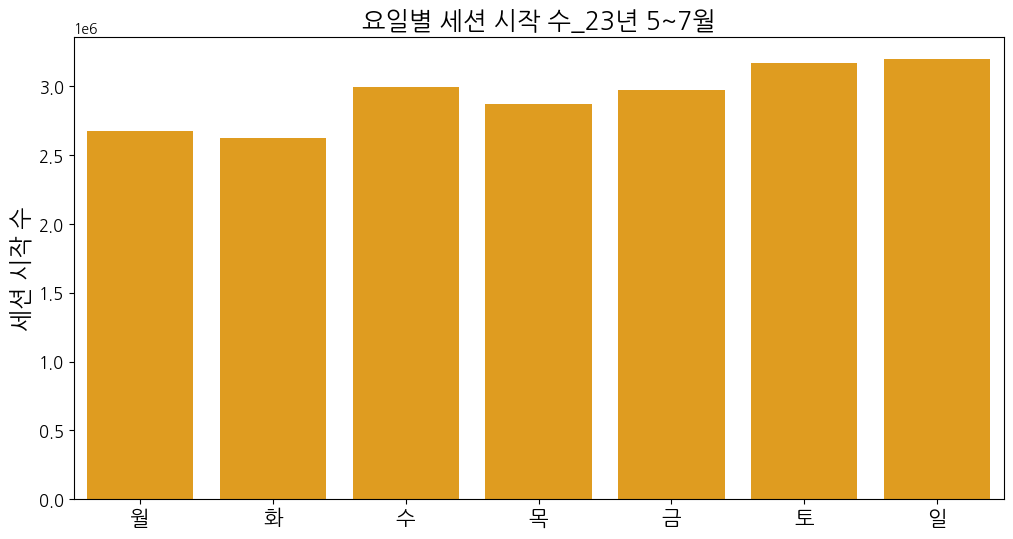

In [6]:
# 요일별로 session_start 수 시각화
plt.figure(figsize=(12, 6))
sns.barplot(data = session_start_week_counts, x = 'event_day_of_week', y = 'session_start_count', color='Orange')
plt.title('요일별 세션 시작 수_23년 5~7월', fontsize = 18)
plt.xlabel('')
plt.ylabel('세션 시작 수', fontsize = 17)   
plt.xticks(ticks = range(7), labels = ['월', '화', '수', '목', '금', '토', '일'], fontsize = 15)
plt.yticks(fontsize = 12)
plt.show()  

,event_hour,count
0,0,1003471
1,1,1266353
2,2,1246948
3,3,1279374
4,4,1313781
5,5,1387890
6,6,1517621
7,7,1642400
8,8,1434009
9,9,1026499


count    2.400000e+01
mean     8.547109e+05
std      4.808628e+05
min      5.516100e+04
25%      5.325498e+05
50%      8.688175e+05
75%      1.269608e+06
max      1.642400e+06
Name: count, dtype: float64

/tmp/ipykernel_10718/1772387672.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data = session_start_hour_counts, x = 'event_hour', y = 'count', palette='Oranges_r')


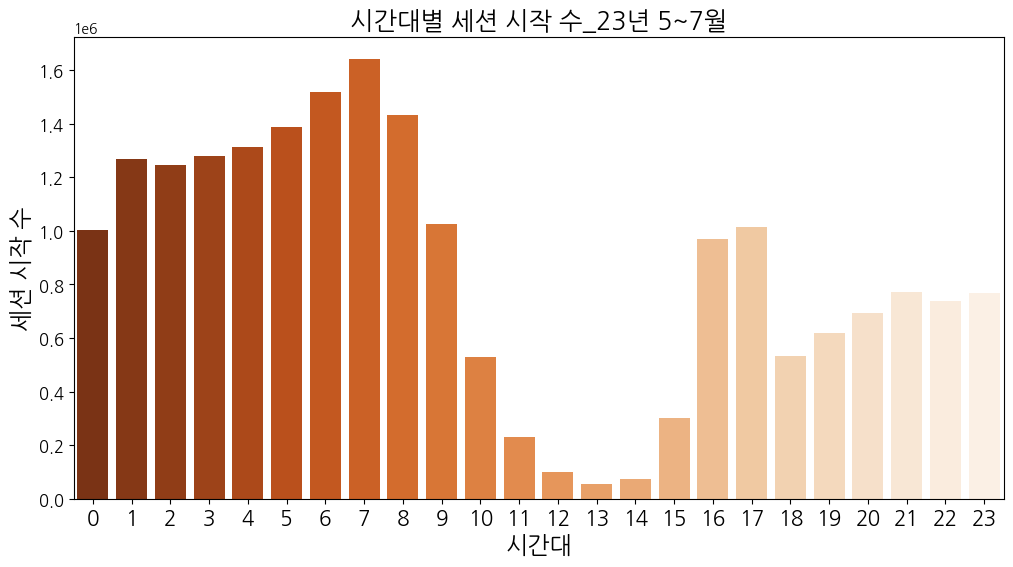

In [7]:
# 시간대별로 session_start 이벤트 개수 집계
session_start_hour_counts = session_start_df['event_hour'].value_counts().sort_index().reset_index()
display(session_start_hour_counts)
display(session_start_hour_counts['count'].describe())

# 시간대별로 session_start 이벤트 개수 시각화
plt.figure(figsize=(12, 6))
sns.barplot(data = session_start_hour_counts, x = 'event_hour', y = 'count', palette='Oranges_r')
plt.title('시간대별 세션 시작 수_23년 5~7월', fontsize = 18)
plt.xlabel('시간대', fontsize = 17)   
plt.ylabel('세션 시작 수', fontsize = 17)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 12)   
plt.show()   

# 지표 도출_세션 지속 시간

In [25]:
# 파일 불러오기(merged_df_final)
# 경로 설정
file_path = "gs://part4_project/events_ver2/merged_df_final.parquet"
key_path = "../config/codeit_project_vm_key.json"

# GCS에서 parquet 불러오기
merged_df = pd.read_parquet(file_path, storage_options={"token": key_path})

# 확인
print(merged_df.shape)
print(merged_df.info())

(55770129, 3)
<class 'pandas.core.frame.DataFrame'>
Index: 55770129 entries, 0 to 2878667
Data columns (total 3 columns):
 #   Column          Dtype         
---  ------          -----         
 0   event_datetime  datetime64[ns]
 1   device_id       object        
 2   event_key       object        
dtypes: datetime64[ns](1), object(2)
memory usage: 1.7+ GB
None


In [4]:
show_df_info(merged_df, 'merged_df')


merged_df 형태:


(55770129, 3)


merged_df 첫 5행:


,event_datetime,device_id,event_key
0,2023-05-01 09:00:00,cfc34eab-6930-488b-8109-70d37cec7dae,button
1,2023-05-01 09:00:00,0dde2ecb-ff03-440f-98f3-94f20978b796,button
2,2023-05-01 09:00:00,b50774ed-24ce-49e1-9383-945ff3aea9ff,button
3,2023-05-01 09:00:00,0999c6b6-c579-4c0f-916c-9a113010f84a,button
4,2023-05-01 09:00:00,45985493-ed35-4cc5-935f-1bcf922e213c,button



merged_df 정보:
<class 'pandas.core.frame.DataFrame'>
Index: 55770129 entries, 0 to 2878667
Data columns (total 3 columns):
 #   Column          Dtype         
---  ------          -----         
 0   event_datetime  datetime64[ns]
 1   device_id       object        
 2   event_key       object        
dtypes: datetime64[ns](1), object(2)
memory usage: 1.7+ GB

merged_df 통계 요약:


,event_datetime
count,55770129
mean,2023-05-28 23:36:05.667766784
min,2023-05-01 09:00:00
25%,2023-05-12 16:25:14
50%,2023-05-19 18:48:13
75%,2023-06-24 04:50:36
max,2023-07-12 08:59:59



merged_df 통계 요약:


,device_id,event_key
count,55770129,55770129
unique,952830,46
top,14f09012-3294-4c51-ad67-e8e09604004f,$session_start
freq,8938,20513061



merged_df 결측치 확인:


event_datetime    0
device_id         0
event_key         0
dtype: int64

In [5]:
# 중복값 확인
merged_df.duplicated().sum()

0

## 세션 관련 EDA (session_start, session_end 탐색)

### 개수 기반 탐색

In [5]:
# device_id 별로 event_key별 개수 확인 
group_device_event_cnt_df = merged_df.groupby('device_id')['event_key'].value_counts().reset_index(name='count')
print(group_device_event_cnt_df.shape)
group_device_event_cnt_df.head()

(4415795, 3)


,device_id,event_key,count
0,0000065b-8c82-4982-b67e-ac67b1e4c38e,$session_start,48
1,0000065b-8c82-4982-b67e-ac67b1e4c38e,$session_end,38
2,0000065b-8c82-4982-b67e-ac67b1e4c38e,view_home_tap,20
3,0000065b-8c82-4982-b67e-ac67b1e4c38e,launch_app,12
4,0000065b-8c82-4982-b67e-ac67b1e4c38e,view_timeline_tap,5


In [6]:
group_device_event_cnt_df['device_id'].nunique() # device_id 952830개

952830

In [7]:
# event_key가 session_start와 session_end인 경우만 필터링
group_device_start_end_df = group_device_event_cnt_df[group_device_event_cnt_df['event_key'].isin(['$session_start', '$session_end'])]

# session_id별로 session_start와 session_end의 개수 확인 
pivot_device_start_end_df = group_device_start_end_df.pivot(index='device_id', columns='event_key', values='count').fillna(0).reset_index()

# 결과 확인
show_df_info(pivot_device_start_end_df,'pivot_device_start_end_df')                               


pivot_device_start_end_df 형태:


(951960, 3)


pivot_device_start_end_df 첫 5행:


event_key,device_id,$session_end,$session_start
0,0000065b-8c82-4982-b67e-ac67b1e4c38e,38.0,48.0
1,000007c9-e103-4eb5-9777-a9084d4952df,7.0,62.0
2,00002245-458f-4cdd-8533-b448cd43dbd2,11.0,17.0
3,00004f65-e8bd-4a40-98af-202f2929dd6d,7.0,9.0
4,00005a56-8ccf-4240-90a0-04fbcf90a45b,17.0,21.0



pivot_device_start_end_df 정보:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 951960 entries, 0 to 951959
Data columns (total 3 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   device_id       951960 non-null  object 
 1   $session_end    951960 non-null  float64
 2   $session_start  951960 non-null  float64
dtypes: float64(2), object(1)
memory usage: 21.8+ MB

pivot_device_start_end_df 통계 요약:


event_key,$session_end,$session_start
count,951960.000000,951960.000000
mean,14.621831,21.548238
std,20.271605,25.073699
min,0.000000,0.000000
25%,1.000000,2.000000
50%,5.000000,12.000000
75%,22.000000,33.000000
max,306.000000,382.000000



pivot_device_start_end_df 통계 요약:


event_key,device_id
count,951960
unique,951960
top,0000065b-8c82-4982-b67e-ac67b1e4c38e
freq,1



pivot_device_start_end_df 결측치 확인:


event_key
device_id         0
$session_end      0
$session_start    0
dtype: int64

- 전체 고유한 device_id 952830개 중에, session_start/end가 없는 device_id 870개 (약 0.09%)
- session_start와 session_end 개수 max 값이 비정상적으로 큰 경우 존재

In [8]:
# session_start/end 별 0 개수 
print((pivot_device_start_end_df['$session_start'] == 0).sum())
print((pivot_device_start_end_df['$session_end'] == 0).sum())

1
193845


- session_start는 0인 경우 딱 1건
- session_end는 0인 경우 193845개...

In [9]:
# session_start는 0이고 session_end는 1이상인 경우
print(((pivot_device_start_end_df['$session_start'] == 0) & (pivot_device_start_end_df['$session_end'] >= 1)).sum())

# session_end가 0이고 session_start는 1이상인 경우 
print(((pivot_device_start_end_df['$session_end'] == 0) & (pivot_device_start_end_df['$session_start'] >= 1)).sum())

1
193845


- sesion_start가 찍히지 않고 session_end만 있는 경우 1개 
- session_end가 찍히지 않고 session_start만 있는 경우 193845개 (약 20.4%)

In [10]:
# session_start와 session_end 개수가 동일한 경우 추출 
pivot_device_start_end_df[pivot_device_start_end_df['$session_end'] == pivot_device_start_end_df['$session_start']] 

event_key,device_id,$session_end,$session_start
112,00088f45-6285-473c-bd06-08701429d051,7.0,7.0
149,000b88ba-1b4a-41e7-8838-95398e1c4761,3.0,3.0
193,000ef6d7-a147-4a2e-93f4-77f088fe867f,2.0,2.0
235,0011eec5-5718-4789-a848-17bdbf8ce29d,1.0,1.0
349,001a3296-b529-44f5-8e3a-d12abe9ac119,3.0,3.0
...,...,...,...
951575,ffe6bcab-69f7-4fca-97a9-ab01852b2d1b,1.0,1.0
951582,ffe72574-fc9f-4afe-abb2-5c2c23cdcb1e,8.0,8.0
951768,fff410f6-3eba-4008-a2bd-2f677e4a697a,2.0,2.0
951772,fff435a5-ed15-4220-83ef-8da89945b509,8.0,8.0


- 951960 개의 device_id중에서 12404개만 session_start와 session_end 개수 동일함 (약 1.30%)

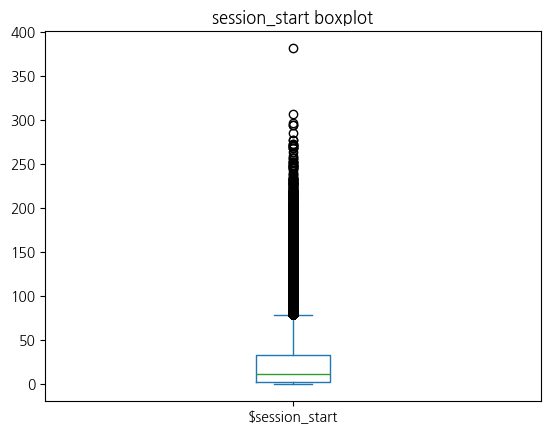

In [11]:
pivot_device_start_end_df['$session_start'].plot(kind = 'box')
plt.title('session_start boxplot')
plt.show()

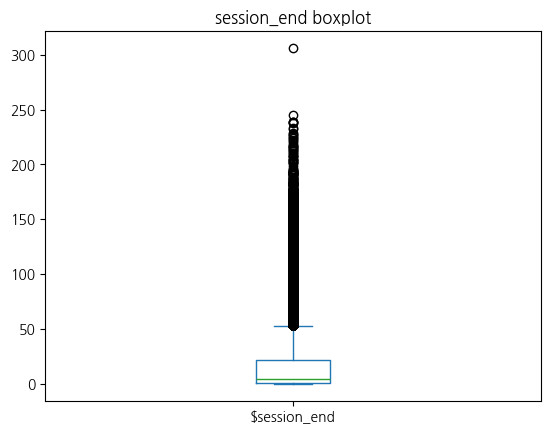

In [12]:
pivot_device_start_end_df['$session_end'].plot(kind = 'box')
plt.title('session_end boxplot')
plt.show()

- 이상치 중에서도 혼자 더 동떨어진 값이 존재 (session_start : 350이상, session_end : 270이상)

In [13]:
# 이상치 확인하기
q3 = pivot_device_start_end_df['$session_start'].quantile(0.75)
q1 = pivot_device_start_end_df['$session_start'].quantile(0.25)
iqr = q3 - q1

upper = q3 + 1.5 * iqr
lower = q1 - 1.5 * iqr

# 이상치 행 탐색
pivot_device_start_end_df[(pivot_device_start_end_df['$session_start'] >= upper) | ((pivot_device_start_end_df['$session_start'] <= lower))]
    

event_key,device_id,$session_end,$session_start
5,00008546-4b7b-47cc-8b61-2ac9ac0745ae,92.0,107.0
21,0001c735-62f3-4888-b063-53ddc0a1a655,110.0,164.0
25,00020cb8-eaad-4b04-b18f-257b01aa60f0,68.0,102.0
80,000615c4-f671-45bb-bea4-7dc810606453,125.0,179.0
123,00097f8b-21e4-482e-80dc-7ee6105eee91,62.0,81.0
...,...,...,...
951910,fffc8f62-9f2b-4b26-8c65-88fd92ad2f41,84.0,95.0
951913,fffca979-e71c-4644-8b58-4823946f64ef,70.0,89.0
951915,fffce6bb-dac6-4f09-b029-730690c7da9e,63.0,87.0
951917,fffcee7c-0ba3-47a4-b382-21be88b88724,76.0,88.0


- 이상치로 분류된 device_id 약 3.60%

In [14]:
# 이상치 확인하기
q3 = pivot_device_start_end_df['$session_end'].quantile(0.75)
q1 = pivot_device_start_end_df['$session_end'].quantile(0.25)
iqr = q3 - q1

upper = q3 + 1.5 * iqr
lower = q1 - 1.5 * iqr

# 이상치 행 탐색
pivot_device_start_end_df[(pivot_device_start_end_df['$session_end'] >= upper) | ((pivot_device_start_end_df['$session_end'] <= lower))]
    

event_key,device_id,$session_end,$session_start
5,00008546-4b7b-47cc-8b61-2ac9ac0745ae,92.0,107.0
14,00018a1a-4204-4efe-8a7f-b4b591d7bb2d,61.0,77.0
21,0001c735-62f3-4888-b063-53ddc0a1a655,110.0,164.0
25,00020cb8-eaad-4b04-b18f-257b01aa60f0,68.0,102.0
41,000352dd-127b-44e6-8a8d-a118b1be5b33,55.0,56.0
...,...,...,...
951906,fffc025f-4da5-4a0f-9c0a-7c64b25cf0ac,54.0,86.0
951910,fffc8f62-9f2b-4b26-8c65-88fd92ad2f41,84.0,95.0
951913,fffca979-e71c-4644-8b58-4823946f64ef,70.0,89.0
951915,fffce6bb-dac6-4f09-b029-730690c7da9e,63.0,87.0


- 이상치로 분류된 device_id 약 5.98%

### 페어링 기반 탐색

In [26]:
# 필요한 컬럼만 추출
device_df = merged_df[merged_df['event_key'].isin(['$session_start', '$session_end'])]
# 시간 순 정렬
device_df = device_df.sort_values(by=['device_id', 'event_datetime']).reset_index(drop=True)
show_df_info(device_df,'device_df')


device_df 형태:


(34432459, 3)


device_df 첫 5행:


,event_datetime,device_id,event_key
0,2023-05-16 18:02:01,0000065b-8c82-4982-b67e-ac67b1e4c38e,$session_start
1,2023-05-16 18:02:48,0000065b-8c82-4982-b67e-ac67b1e4c38e,$session_end
2,2023-05-16 18:02:50,0000065b-8c82-4982-b67e-ac67b1e4c38e,$session_start
3,2023-05-16 21:41:52,0000065b-8c82-4982-b67e-ac67b1e4c38e,$session_end
4,2023-05-16 23:43:19,0000065b-8c82-4982-b67e-ac67b1e4c38e,$session_start



device_df 정보:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34432459 entries, 0 to 34432458
Data columns (total 3 columns):
 #   Column          Dtype         
---  ------          -----         
 0   event_datetime  datetime64[ns]
 1   device_id       object        
 2   event_key       object        
dtypes: datetime64[ns](1), object(2)
memory usage: 788.1+ MB

device_df 통계 요약:


,event_datetime
count,34432459
mean,2023-05-21 04:38:13.430996736
min,2023-05-01 09:00:00
25%,2023-05-13 19:58:01
50%,2023-05-18 00:17:34
75%,2023-05-22 07:15:03
max,2023-07-12 08:59:59



device_df 통계 요약:


,device_id,event_key
count,34432459,34432459
unique,951960,2
top,ca1a4a21-36a2-45cc-b7d2-09c4404ccaf0,$session_start
freq,688,20513061



device_df 결측치 확인:


event_datetime    0
device_id         0
event_key         0
dtype: int64

In [5]:
# 중복값 확인
device_df.duplicated().sum()

0

In [27]:
## 동일 device_id에서 start_time == end_time 인 경우는 제외
# 1. device_id + event_datetime + event_key 기준으로 개수 세기
event_counts = (
    device_df.groupby(['device_id', 'event_datetime', 'event_key'])
    .size()
    .unstack(fill_value=0)
    .reset_index()
)

# 2. start와 end가 동시에 존재하는 행 (동일한 datetime에 start와 end 둘 다 있는 경우)
duplicates = event_counts[
    (event_counts.get('$session_start', 0) > 0) &
    (event_counts.get('$session_end', 0) > 0)
]

# 3. 이 조건을 만족하는 (device_id, event_datetime)만 뽑기
dupe_keys = duplicates[['device_id', 'event_datetime']]

# 4. 원본에서 이 쌍들을 제거
device_df_filtered = device_df.merge(dupe_keys, on=['device_id', 'event_datetime'], how='left', indicator=True)
device_df_filtered = device_df_filtered[device_df_filtered['_merge'] == 'left_only'].drop(columns=['_merge'])

# 🔄 인덱스 초기화
device_df_filtered = device_df_filtered.reset_index(drop=True)

# 확인
show_df_info(device_df_filtered,'device_df_filtered')


device_df_filtered 형태:


(33306925, 3)


device_df_filtered 첫 5행:


,event_datetime,device_id,event_key
0,2023-05-16 18:02:01,0000065b-8c82-4982-b67e-ac67b1e4c38e,$session_start
1,2023-05-16 18:02:48,0000065b-8c82-4982-b67e-ac67b1e4c38e,$session_end
2,2023-05-16 18:02:50,0000065b-8c82-4982-b67e-ac67b1e4c38e,$session_start
3,2023-05-16 21:41:52,0000065b-8c82-4982-b67e-ac67b1e4c38e,$session_end
4,2023-05-16 23:43:19,0000065b-8c82-4982-b67e-ac67b1e4c38e,$session_start



device_df_filtered 정보:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33306925 entries, 0 to 33306924
Data columns (total 3 columns):
 #   Column          Dtype         
---  ------          -----         
 0   event_datetime  datetime64[ns]
 1   device_id       object        
 2   event_key       object        
dtypes: datetime64[ns](1), object(2)
memory usage: 762.3+ MB

device_df_filtered 통계 요약:


,event_datetime
count,33306925
mean,2023-05-20 07:30:23.965038848
min,2023-05-01 09:00:00
25%,2023-05-13 17:25:47
50%,2023-05-17 18:44:30
75%,2023-05-22 02:23:16
max,2023-07-12 08:59:59



device_df_filtered 통계 요약:


,device_id,event_key
count,33306925,33306925
unique,947788,2
top,ca1a4a21-36a2-45cc-b7d2-09c4404ccaf0,$session_start
freq,684,19950294



device_df_filtered 결측치 확인:


event_datetime    0
device_id         0
event_key         0
dtype: int64

In [ ]:
(34432459 - 33306925) / 34432459 * 100 # 전체의 약 3.3% 행 제거 

3.268816787090344

In [6]:
# device_id 별로 총 행 수 얼마인지 체크 
device_counts = device_df_filtered['device_id'].value_counts()
device_counts.describe()

count    947788.000000
mean         35.141746
std          43.770920
min           1.000000
25%           3.000000
50%          17.000000
75%          53.000000
max         684.000000
Name: count, dtype: float64

In [ ]:
for p in [0.65,0.7,0.8,0.85,0.9,0.95, 0.97, 0.99,0.9991, 0.9993, 0.9995, 0.9997, 0.9999, 1]:
    print(device_counts.quantile(p))


64.0
78.0
96.0
125.0
146.0
189.0
284.0
294.0
308.0
333.0
383.0
684.0


In [10]:
# 분위수 기준 나누기
cut_1 = device_counts.quantile(0.4) # 13
cut_2 = device_counts.quantile(0.6) # 21
cut_3 = device_counts.quantile(0.8) # 39
cut_4 = device_counts.quantile(0.93) # 74
cut_5 = device_counts.quantile(0.97) # 111
cut_6 = device_counts.quantile(0.99) # 173


# 각 그룹별 device_id
group_1_ids = device_counts[device_counts <= cut_1].index
group_2_ids = device_counts[(device_counts > cut_1) & (device_counts <= cut_2)].index
group_3_ids = device_counts[(device_counts > cut_2) & (device_counts <= cut_3)].index
group_4_ids = device_counts[(device_counts > cut_3) & (device_counts <= cut_4)].index
group_5_ids = device_counts[(device_counts > cut_4) & (device_counts <= cut_5)].index
group_6_ids = device_counts[(device_counts > cut_5) & (device_counts <= cut_6)].index
group_7_ids = device_counts[device_counts > cut_6].index


# 각 그룹별 데이터프레임 생성
group_1_df = device_df_filtered[device_df_filtered['device_id'].isin(group_1_ids)]
group_2_df = device_df_filtered[device_df_filtered['device_id'].isin(group_2_ids)]
group_3_df = device_df_filtered[device_df_filtered['device_id'].isin(group_3_ids)]
group_4_df = device_df_filtered[device_df_filtered['device_id'].isin(group_4_ids)]
group_5_df = device_df_filtered[device_df_filtered['device_id'].isin(group_5_ids)]
group_6_df = device_df_filtered[device_df_filtered['device_id'].isin(group_6_ids)]
group_7_df = device_df_filtered[device_df_filtered['device_id'].isin(group_7_ids)]

# 각 그룹별 형태 확인 
print(f"group_1_df: {group_1_df.shape}, {group_1_df['device_id'].nunique()}")
print(f"group_2_df: {group_2_df.shape}, {group_2_df['device_id'].nunique()}")
print(f"group_3_df: {group_3_df.shape}, {group_3_df['device_id'].nunique()}")
print(f"group_4_df: {group_4_df.shape}, {group_4_df['device_id'].nunique()}")
print(f"group_5_df: {group_5_df.shape}, {group_5_df['device_id'].nunique()}")
print(f"group_6_df: {group_6_df.shape}, {group_6_df['device_id'].nunique()}")
print(f"group_7_df: {group_7_df.shape}, {group_7_df['device_id'].nunique()}")
print(f"총합 확인: {group_1_df.shape[0] + group_2_df.shape[0] + group_3_df.shape[0] + group_4_df.shape[0] + group_5_df.shape[0] + group_6_df.shape[0] + group_7_df.shape[0]}")

group_1_df: (1303382, 3), 390929
group_2_df: (3234971, 3), 179144
group_3_df: (8484426, 3), 190563
group_4_df: (10249798, 3), 121085
group_5_df: (4797121, 3), 37864
group_6_df: (3081471, 3), 18785
group_7_df: (2155756, 3), 9418
총합 확인: 33306925


In [ ]:
# group_4_df 다시 쪼개기 
unique_ids = group_4_df['device_id'].unique()
half = len(unique_ids) // 2

ids_1 = unique_ids[:half]
ids_2 = unique_ids[half:]

group_4_df_1 = group_4_df[group_4_df['device_id'].isin(ids_1)]
group_4_df_2 = group_4_df[group_4_df['device_id'].isin(ids_2)]


print(f"group_4_df_1: {group_4_df_1.shape}, {group_4_df_1['device_id'].nunique()}")
print(f"group_4_df_2: {group_4_df_2.shape}, {group_4_df_2['device_id'].nunique()}")


group_4_df_1: (5122630, 3), 60542
group_4_df_2: (5127168, 3), 60543


In [12]:
# parquet으로 저장 
group_1_df.to_parquet(f"../data/group_1_df.parquet", engine="pyarrow", compression="snappy")
group_2_df.to_parquet(f"../data/group_2_df.parquet", engine="pyarrow", compression="snappy")
group_3_df.to_parquet(f"../data/group_3_df.parquet", engine="pyarrow", compression="snappy")
group_4_df_1.to_parquet(f"../data/group_4_df_1.parquet", engine="pyarrow", compression="snappy")
group_4_df_2.to_parquet(f"../data/group_4_df_2.parquet", engine="pyarrow", compression="snappy")
group_5_df.to_parquet(f"../data/group_5_df.parquet", engine="pyarrow", compression="snappy")
group_6_df.to_parquet(f"../data/group_6_df.parquet", engine="pyarrow", compression="snappy")
group_7_df.to_parquet(f"../data/group_7_df.parquet", engine="pyarrow", compression="snappy")

### 폐기된 방식 (start, end 각각의 순서 기반 매칭)

In [ ]:
# ## 다른 방법 시도

# def match_sessions_with_flags(df):
    
#     # # 시간 순 정렬
#     # df = df.sort_values(by=['device_id', 'event_datetime']).reset_index(drop=True)
    
#     # start, end 분리
#     start_df = df[df['event_key'] == '$session_start'].copy()
#     end_df = df[df['event_key'] == '$session_end'].copy()

#     start_df = start_df.rename(columns={'event_datetime': 'start_time'})
#     end_df = end_df.rename(columns={'event_datetime': 'end_time'})

#     # 각 device_id 내에서 순서 부여
#     start_df['session_num'] = start_df.groupby('device_id').cumcount()
#     end_df['session_num'] = end_df.groupby('device_id').cumcount()

#     # outer join으로 start, end 모두 포함
#     merged = pd.merge(start_df[['device_id', 'session_num', 'start_time']],
#                       end_df[['device_id', 'session_num', 'end_time']],
#                       on=['device_id', 'session_num'],
#                       how='outer')

#     # 세션 길이 계산 (HH:MM:SS)
#     def format_duration(row):
#         if pd.notnull(row['start_time']) and pd.notnull(row['end_time']):
#             duration = (row['end_time'] - row['start_time']).total_seconds()
#             hours = int(duration // 3600)
#             minutes = int((duration % 3600) // 60)
#             seconds = int(duration % 60)
#             return f"{hours:02}:{minutes:02}:{seconds:02}"
#         else:
#             return None

#     merged['session_duration'] = merged.apply(format_duration, axis=1)

#     # 플래그 추가
#     def get_flag(row):
#         if pd.notnull(row['start_time']) and pd.notnull(row['end_time']):
#             return 'matched'
#         elif pd.notnull(row['start_time']) and pd.isna(row['end_time']):
#             return 'start_only'
#         elif pd.isna(row['start_time']) and pd.notnull(row['end_time']):
#             return 'end_only'
#         else:
#             return 'unknown'

#     merged['session_flag'] = merged.apply(get_flag, axis=1)

#     # 정렬
#     merged = merged.sort_values(by=['device_id', 'start_time', 'end_time']).reset_index(drop=True)

#     return merged


In [5]:
# print(matched_device_df['session_flag'].value_counts())
# print(matched_device_df['session_flag'].value_counts(normalize=True))  # 비율

### 최종 방식

In [8]:
## 재재 수정본
# import pandas as pd
# import numpy as np
# import multiprocessing as mp

# ▶︎ 1. 정확한 세션 매칭 함수: 가장 가까운 과거 start에 end 매칭
def match_sessions_buffer_corrected(group_df):
    """
    device_id별로 $session_start와 $session_end를 1:1로 정확히 매칭
    - end 이벤트가 오면 그보다 이전에 발생한 start 중 "가장 가까운" start에 매칭
    - 매칭되지 않은 start나 end는 NaT로 남김
    """
    matched_sessions = []

    for device_id, group in group_df.groupby('device_id'):
        starts = []
        used_indices = set()
        group = group.sort_values(by='event_datetime').reset_index(drop=True)

        for idx, row in group.iterrows():
            if row['event_key'] == '$session_start':
                starts.append({
                    'index': idx,
                    'start_time': row['event_datetime'],
                    'end_time': pd.NaT,
                    'matched': False
                })

        for idx, row in group.iterrows():
            if row['event_key'] == '$session_end':
                # 가능한 start 중 end보다 같거나 작고, 아직 매칭되지 않은 가장 최근 start 찾기
                candidates = [s for s in starts if not s['matched'] and s['start_time'] <= row['event_datetime']]
                if candidates:
                    latest_start = max(candidates, key=lambda x: x['start_time'])
                    latest_start['end_time'] = row['event_datetime']
                    latest_start['matched'] = True
                else:
                    # 매칭 안 되는 end는 따로 기록
                    matched_sessions.append({
                        'device_id': device_id,
                        'start_time': pd.NaT,
                        'end_time': row['event_datetime'],
                        'session_duration_sec': np.nan
                    })

        # 최종 세션 리스트로 구성
        for s in starts:
            matched_sessions.append({
                'device_id': device_id,
                'start_time': s['start_time'],
                'end_time': s['end_time'],
                'session_duration_sec': (
                    (s['end_time'] - s['start_time']).total_seconds() if pd.notna(s['end_time']) else np.nan
                )
            })
    return pd.DataFrame(matched_sessions)


def split_by_device_id(df, n_splits):
    """
    device_id 단위로 groupby 후 균등하게 분할하여 list로 반환
    하나의 device에 속한 모든 이벤트가 같은 덩어리에 있도록 유지함
    """
    grouped = list(df.groupby('device_id'))
    split_size = int(np.ceil(len(grouped) / n_splits))
    return [pd.concat([g for _, g in grouped[i:i + split_size]])
            for i in range(0, len(grouped), split_size)]


def match_sessions_parallel(df, n_cores=None):
    """
    device_id 기준으로 분할된 DataFrame을 병렬 처리하여 세션 매칭
    """
    if n_cores is None:
        n_cores = mp.cpu_count()

    # 정렬: 병렬 처리 전에 전체를 정렬해야 안정성 확보
    df = df.sort_values(by=['device_id', 'event_datetime']).reset_index(drop=True)
    
    # device_id 기준으로 분할
    df_splits = split_by_device_id(df, n_cores)

    # 병렬 실행
    with mp.Pool(n_cores) as pool:
        results = pool.map(match_sessions_buffer_corrected, df_splits)

    return pd.concat(results, ignore_index=True)


In [3]:
## matched_device_df 불러오기 
## 쪼갠 df를 'match_session.ipynb'에서 작업 후 여기서 최종 matched_device_df 불러와서 진행

matched_device_df = pd.read_parquet("/home/codeit_project_vm/codeit_project/codeit-project-docker/data/matched_device_df.parquet")

print(matched_device_df.shape)

(19984291, 4)


In [4]:
show_df_info(matched_device_df,'matched_device_df')


matched_device_df 형태:


(19984291, 4)


matched_device_df 첫 5행:


,device_id,start_time,end_time,session_duration_sec
0,00018a1a-4204-4efe-8a7f-b4b591d7bb2d,2023-05-11 21:47:43,2023-05-11 21:48:05,22.0
1,00018a1a-4204-4efe-8a7f-b4b591d7bb2d,2023-05-11 21:48:06,2023-05-11 21:49:50,104.0
2,00018a1a-4204-4efe-8a7f-b4b591d7bb2d,2023-05-11 22:52:45,2023-05-12 00:49:43,7018.0
3,00018a1a-4204-4efe-8a7f-b4b591d7bb2d,2023-05-12 03:23:34,2023-05-12 03:24:09,35.0
4,00018a1a-4204-4efe-8a7f-b4b591d7bb2d,2023-05-12 03:26:37,2023-05-12 04:44:56,4699.0



matched_device_df 정보:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19984291 entries, 0 to 19984290
Data columns (total 4 columns):
 #   Column                Dtype         
---  ------                -----         
 0   device_id             object        
 1   start_time            datetime64[ns]
 2   end_time              datetime64[ns]
 3   session_duration_sec  float64       
dtypes: datetime64[ns](2), float64(1), object(1)
memory usage: 609.9+ MB

matched_device_df 통계 요약:


,start_time,end_time,session_duration_sec
count,19950294,13356631,1.332263e+07
mean,2023-05-21 11:35:44.834389760,2023-05-18 13:33:03.551259136,1.545506e+04
min,2023-05-01 09:00:01,2023-05-01 09:00:00,1.000000e+00
25%,2023-05-14 06:12:07,2023-05-12 17:32:13,5.800000e+01
50%,2023-05-19 03:12:02,2023-05-16 07:38:26,4.370000e+02
75%,2023-05-24 08:03:30,2023-05-19 19:00:11,4.310000e+03
max,2023-07-12 08:59:59,2023-07-12 08:59:59,6.132709e+06
std,NaN,NaN,1.003533e+05



matched_device_df 통계 요약:


,device_id
count,19984291
unique,947788
top,ca1a4a21-36a2-45cc-b7d2-09c4404ccaf0
freq,380



matched_device_df 결측치 확인:


device_id                     0
start_time                33997
end_time                6627660
session_duration_sec    6661657
dtype: int64

- device_id 947788개 유지!! 
- session_duration_sec : 기존 hackle 처럼 3사분위수 ~ MAX 범위가 넓다 아주!! 극단적 이상치 존재..

In [ ]:
6661657 / 19984291 * 100 # 전체의 약 33%행 결측치 

33.33446755754307

In [4]:
# start_time과 end_time 모두 있는 경우 : matched
# start만 : start_only
# end만 : end_only

# 페어링 여부 컬럼 추가 
def check_matched(row):
    if pd.notnull(row['start_time']) and pd.notnull(row['end_time']):
        return 'matched'
    elif pd.notnull(row['start_time']) and pd.isna(row['end_time']):
        return 'start_only'
    elif pd.isna(row['start_time']) and pd.notnull(row['end_time']):
        return 'end_only'
    else:
        return 'unknown'

matched_device_df['session_flag'] = matched_device_df.apply(check_matched, axis=1) 
matched_device_df.head()

,device_id,start_time,end_time,session_duration_sec,session_flag
0,00018a1a-4204-4efe-8a7f-b4b591d7bb2d,2023-05-11 21:47:43,2023-05-11 21:48:05,22.0,matched
1,00018a1a-4204-4efe-8a7f-b4b591d7bb2d,2023-05-11 21:48:06,2023-05-11 21:49:50,104.0,matched
2,00018a1a-4204-4efe-8a7f-b4b591d7bb2d,2023-05-11 22:52:45,2023-05-12 00:49:43,7018.0,matched
3,00018a1a-4204-4efe-8a7f-b4b591d7bb2d,2023-05-12 03:23:34,2023-05-12 03:24:09,35.0,matched
4,00018a1a-4204-4efe-8a7f-b4b591d7bb2d,2023-05-12 03:26:37,2023-05-12 04:44:56,4699.0,matched


In [5]:
# session_flag 별 확인
print('\nsession 매칭 여부 별 개수')
print(matched_device_df['session_flag'].value_counts())
print('\nsession 매칭 여부 별 개수 비율')
print(matched_device_df['session_flag'].value_counts(normalize=True))  # 비율


session 매칭 여부 별 개수
session_flag
matched       13322634
start_only     6627660
end_only         33997
Name: count, dtype: int64

session 매칭 여부 별 개수 비율
session_flag
matched       0.666655
start_only    0.331643
end_only      0.001701
Name: proportion, dtype: float64


- 역시 기존 hackle과 비슷하게 약 67%의 matched 쌍 존재!! (전체의 67%라고 해도 천만행이 넘음)
- 나머지 33%의 결측치는 버리고 진행

#### start_time, end_time 결측치 보정(중앙값으로) -> 폐기!! 보정 없이 matched 된 경우만 사용

In [ ]:
# # start가 결측인 경우 end - 중앙값  / end가 결측인 경우 start + 중앙값 
# # 중앙값을 timedelta로 변환
# duration_median = matched_device_df[matched_device_df['session_flag'] == 'matched']['session_duration_sec'].median()
# duration_td = pd.to_timedelta(duration_median, unit='s')

# # 마스크 조건 설정
# start_null = matched_device_df['start_time'].isnull() & matched_device_df['end_time'].notnull()
# end_null = matched_device_df['end_time'].isnull() & matched_device_df['start_time'].notnull()

# # 결측값 보정: start_time이 결측인 경우
# matched_device_df.loc[start_null, 'start_time'] = matched_device_df.loc[start_null, 'end_time'] - duration_td
# matched_device_df.loc[start_null, 'session_duration_sec'] = duration_median

# # 결측값 보정: end_time이 결측인 경우
# matched_device_df.loc[end_null, 'end_time'] = matched_device_df.loc[end_null, 'start_time'] + duration_td
# matched_device_df.loc[end_null, 'session_duration_sec'] = duration_median


## 지표 작업

In [6]:
# matched인 경우만 따로 추출
matched_df = matched_device_df[matched_device_df['session_flag'] == 'matched']

In [7]:
show_df_info(matched_df,'matched_df')


matched_df 형태:


(13322634, 5)


matched_df 첫 5행:


,device_id,start_time,end_time,session_duration_sec,session_flag
0,00018a1a-4204-4efe-8a7f-b4b591d7bb2d,2023-05-11 21:47:43,2023-05-11 21:48:05,22.0,matched
1,00018a1a-4204-4efe-8a7f-b4b591d7bb2d,2023-05-11 21:48:06,2023-05-11 21:49:50,104.0,matched
2,00018a1a-4204-4efe-8a7f-b4b591d7bb2d,2023-05-11 22:52:45,2023-05-12 00:49:43,7018.0,matched
3,00018a1a-4204-4efe-8a7f-b4b591d7bb2d,2023-05-12 03:23:34,2023-05-12 03:24:09,35.0,matched
4,00018a1a-4204-4efe-8a7f-b4b591d7bb2d,2023-05-12 03:26:37,2023-05-12 04:44:56,4699.0,matched



matched_df 정보:
<class 'pandas.core.frame.DataFrame'>
Index: 13322634 entries, 0 to 19984284
Data columns (total 5 columns):
 #   Column                Dtype         
---  ------                -----         
 0   device_id             object        
 1   start_time            datetime64[ns]
 2   end_time              datetime64[ns]
 3   session_duration_sec  float64       
 4   session_flag          object        
dtypes: datetime64[ns](2), float64(1), object(2)
memory usage: 609.9+ MB

matched_df 통계 요약:


,start_time,end_time,session_duration_sec
count,13322634,13322634,1.332263e+07
mean,2023-05-18 09:29:57.301112320,2023-05-18 13:47:32.363166976,1.545506e+04
min,2023-05-01 09:00:01,2023-05-01 09:00:08,1.000000e+00
25%,2023-05-12 09:11:06,2023-05-12 17:41:34,5.800000e+01
50%,2023-05-16 05:23:40,2023-05-16 07:42:20,4.370000e+02
75%,2023-05-19 15:59:51,2023-05-19 19:06:06,4.310000e+03
max,2023-07-12 08:59:35,2023-07-12 08:59:59,6.132709e+06
std,NaN,NaN,1.003533e+05



matched_df 통계 요약:


,device_id,session_flag
count,13322634,13322634
unique,716636,1
top,ca1a4a21-36a2-45cc-b7d2-09c4404ccaf0,matched
freq,304,13322634



matched_df 결측치 확인:


device_id               0
start_time              0
end_time                0
session_duration_sec    0
session_flag            0
dtype: int64

In [ ]:
matched_df['session_duration_sec'].value_counts() # start == end 인 경우는 미리 제거하고 진행하였음, 추가 확인 완

session_duration_sec
1.0         113195
2.0          96030
7.0          95364
8.0          94719
9.0          91687
             ...  
423698.0         1
263579.0         1
332066.0         1
168865.0         1
150630.0         1
Name: count, Length: 306443, dtype: int64

In [ ]:
Q1 = matched_df['session_duration_sec'].quantile(0.25)
Q3 = matched_df['session_duration_sec'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR # 10688초 (2시간 58분)
lower_bound, upper_bound

(-6320.0, 10688.0)

In [ ]:
(matched_df['session_duration_sec'] > upper_bound).sum() / len(matched_df['session_duration_sec']) * 100 # 17%가 이상치

17.265362089808967

In [36]:
# 초 → HH:MM:SS 변환 함수
def seconds_to_hms(seconds):
    seconds = int(seconds)
    hours = seconds // 3600
    minutes = (seconds % 3600) // 60
    secs = seconds % 60
    return f'{hours:02}:{minutes:02}:{secs:02}'

# 상위 1% ~ 10%까지 확인
percentiles = [0.9, 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99]
summary_list = []

# 반복 처리
for p in percentiles:
    cut = matched_df['session_duration_sec'].quantile(p)
    temp = matched_df[matched_df['session_duration_sec'] > cut]
    
    summary = {
        '상위 비율': f'{round((1 - p) * 100, 1)}%',
        '컷오프 (초)': round(cut, 2),
        '컷오프 (시:분:초)': seconds_to_hms(cut),
        '개수': temp.shape[0],
        '최소': seconds_to_hms(temp['session_duration_sec'].min()),
        '25%': seconds_to_hms(temp['session_duration_sec'].quantile(0.25)),
        '50% (중앙값)': seconds_to_hms(temp['session_duration_sec'].quantile(0.5)),
        '75%': seconds_to_hms(temp['session_duration_sec'].quantile(0.75)),
        '평균': seconds_to_hms(temp['session_duration_sec'].mean()),
        '최대': seconds_to_hms(temp['session_duration_sec'].max())
    }
    summary_list.append(summary)

# 결과 데이터프레임
summary_df = pd.DataFrame(summary_list)
display(summary_df)



,상위 비율,컷오프 (초),컷오프 (시:분:초),개수,최소,25%,50% (중앙값),75%,평균,최대
0,10.0%,32628.00,09:03:48,1332256,09:03:49,12:34:34,18:24:40,29:21:37,36:05:10,1703:31:49
1,9.0%,36716.00,10:11:56,1199026,10:11:57,14:09:09,19:49:34,33:00:03,39:01:41,1703:31:49
2,8.0%,42024.00,11:40:24,1065809,11:40:25,15:55:33,21:24:17,37:04:37,42:32:37,1703:31:49
3,7.0%,48971.00,13:36:11,932577,13:36:12,17:45:37,23:08:20,41:30:50,46:49:19,1703:31:49
4,6.0%,57333.00,15:55:33,799351,15:55:34,19:49:34,25:12:08,45:45:12,52:10:07,1703:31:49
5,5.0%,66280.00,18:24:40,666127,18:24:41,22:15:10,29:21:37,50:12:01,59:10:23,1703:31:49
6,4.0%,77057.00,21:24:17,532902,21:24:18,25:12:08,37:04:38,60:43:19,69:00:10,1703:31:49
7,3.0%,90728.00,25:12:08,399673,25:12:09,33:00:04,45:45:12,72:16:14,84:16:35,1703:31:49
8,2.0%,133477.00,37:04:37,266451,37:04:39,45:45:12,60:43:20,94:37:11,111:24:13,1703:31:49
9,1.0%,218597.01,60:43:17,133227,60:43:18,72:16:12,94:37:11,145:24:04,176:23:06,1703:31:49


In [37]:
# 상위 1% ~ 0.1%까지 확인
percentiles = [0.990, 0.991, 0.992, 0.993, 0.994, 0.995, 0.996, 0.997, 0.998, 0.999]
summary_list = []

# 반복 처리
for p in percentiles:
    cut = matched_df['session_duration_sec'].quantile(p)
    temp = matched_df[matched_df['session_duration_sec'] > cut]
    
    summary = {
        '상위 비율': f'{round((1 - p) * 100, 1)}%',
        '컷오프 (초)': round(cut, 2),
        '컷오프 (시:분:초)': seconds_to_hms(cut),
        '개수': temp.shape[0],
        '최소': seconds_to_hms(temp['session_duration_sec'].min()),
        '25%': seconds_to_hms(temp['session_duration_sec'].quantile(0.25)),
        '50% (중앙값)': seconds_to_hms(temp['session_duration_sec'].quantile(0.5)),
        '75%': seconds_to_hms(temp['session_duration_sec'].quantile(0.75)),
        '평균': seconds_to_hms(temp['session_duration_sec'].mean()),
        '최대': seconds_to_hms(temp['session_duration_sec'].max())
    }
    summary_list.append(summary)

# 결과 데이터프레임
summary_df = pd.DataFrame(summary_list)
display(summary_df)

,상위 비율,컷오프 (초),컷오프 (시:분:초),개수,최소,25%,50% (중앙값),75%,평균,최대
0,1.0%,218597.01,60:43:17,133227,60:43:18,72:16:12,94:37:11,145:24:04,176:23:06,1703:31:49
1,0.9%,236735.61,65:45:35,119904,65:45:37,76:46:25,99:33:52,157:44:27,188:57:13,1703:31:49
2,0.8%,253069.81,70:17:49,106582,70:17:50,84:46:40,109:24:16,168:57:50,204:03:40,1703:31:49
3,0.7%,269680.41,74:54:40,93259,74:54:43,92:24:17,118:31:36,189:42:54,222:52:14,1703:31:49
4,0.6%,305199.62,84:46:39,79936,84:46:46,99:33:55,130:07:32,221:17:55,246:46:49,1703:31:49
5,0.5%,340630.67,94:37:10,66614,94:37:11,114:25:29,145:24:04,310:48:41,278:09:04,1703:31:49
6,0.4%,393856.47,109:24:16,53291,109:24:17,130:07:32,168:57:53,617:52:54,322:33:40,1703:31:49
7,0.3%,468441.63,130:07:21,39968,130:07:45,157:44:31,221:18:28,623:18:55,390:29:50,1703:31:49
8,0.2%,608269.81,168:57:49,26646,168:57:53,221:17:55,617:52:54,644:37:54,511:46:36,1703:31:49
9,0.1%,2224373.73,617:52:53,13323,617:52:55,623:18:56,644:38:00,758:14:04,725:10:48,1703:31:49


In [8]:
# matched_session_df는 상위 0.5% (74416.27; 약 20시간 40분 이상은 커트함)
# 비슷한 수준으로 유지하면서 이상치 제거해봄

# 상위 4% 커트 기준
cutoff = matched_df['session_duration_sec'].quantile(0.96)

# 이상치 제거된 데이터프레임
cleaned_df = matched_df[matched_df['session_duration_sec'] <= cutoff]

# 상위 4% 이상치 따로 저장 
outliers_df = matched_df[matched_df['session_duration_sec'] > cutoff]

In [9]:
print(cleaned_df.shape) # matched_df의 약 96% 유지됨! 
cleaned_df.describe(include = 'all')

(12789732, 5)


,device_id,start_time,end_time,session_duration_sec,session_flag
count,12789732,12789732,12789732,1.278973e+07,12789732
unique,711926,NaN,NaN,NaN,1
top,ca1a4a21-36a2-45cc-b7d2-09c4404ccaf0,NaN,NaN,NaN,matched
freq,303,NaN,NaN,NaN,12789732
mean,NaN,2023-05-18 13:10:08.910161408,2023-05-18 14:45:57.562395392,5.748652e+03,NaN
min,NaN,2023-05-01 09:00:01,2023-05-01 09:00:08,1.000000e+00,NaN
25%,NaN,2023-05-12 15:41:33,2023-05-12 17:22:01,5.300000e+01,NaN
50%,NaN,2023-05-16 06:43:56,2023-05-16 07:39:28,3.530000e+02,NaN
75%,NaN,2023-05-19 17:14:08,2023-05-19 19:09:50,3.214000e+03,NaN
max,NaN,2023-07-12 08:59:35,2023-07-12 08:59:59,7.705700e+04,NaN


### device별 평균 세션 지속 시간 집계

In [10]:
# device_id별 평균 세션 지속시간
avg_duration_df = cleaned_df.groupby('device_id')['session_duration_sec'].mean().reset_index(name = 'avg_duration_sec')
# 확인
show_df_info(avg_duration_df,'avg_duration_df')


avg_duration_df 형태:


(711926, 2)


avg_duration_df 첫 5행:


,device_id,avg_duration_sec
0,0000065b-8c82-4982-b67e-ac67b1e4c38e,2386.457143
1,000007c9-e103-4eb5-9777-a9084d4952df,81.000000
2,00002245-458f-4cdd-8533-b448cd43dbd2,4598.125000
3,00004f65-e8bd-4a40-98af-202f2929dd6d,20671.200000
4,00005a56-8ccf-4240-90a0-04fbcf90a45b,9998.250000



avg_duration_df 정보:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 711926 entries, 0 to 711925
Data columns (total 2 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   device_id         711926 non-null  object 
 1   avg_duration_sec  711926 non-null  float64
dtypes: float64(1), object(1)
memory usage: 10.9+ MB

avg_duration_df 통계 요약:


,avg_duration_sec
count,711926.000000
mean,5603.163180
std,7190.689590
min,1.000000
25%,141.000000
50%,3129.048131
75%,8452.293269
max,77034.000000



avg_duration_df 통계 요약:


,device_id
count,711926
unique,711926
top,0000065b-8c82-4982-b67e-ac67b1e4c38e
freq,1



avg_duration_df 결측치 확인:


device_id           0
avg_duration_sec    0
dtype: int64

In [21]:
avg_duration_df.sort_values('avg_duration_sec',ascending=False)

,device_id,avg_duration_sec
12238,04636447-9611-4f92-a5a7-75cc461806b2,77034.0
5283,01eb2974-73ef-4ca6-b58a-f5c4ebb8e0f6,77011.0
387328,8b9d66a3-9315-4363-8afa-836482ab7207,76973.0
517204,ba44cf3f-6278-4604-a123-7450f19b4abf,76964.0
531125,bf4caab7-931f-47bf-8e76-1662a07b4b06,76949.0
...,...,...
586695,d3287e98-5411-4461-b4b5-ecb4f545ff63,1.0
602841,d8faac4f-e22d-45a9-8706-27ef0eb6cb02,1.0
667014,efd68de6-09d3-4876-845e-dee1e029cf14,1.0
513608,b9053728-ef47-45ce-af57-3a770b698402,1.0


In [22]:
# 최장 세션길이 탐색
matched_df[matched_df['device_id'] == '04636447-9611-4f92-a5a7-75cc461806b2']

,device_id,start_time,end_time,session_duration_sec,session_flag
13581177,04636447-9611-4f92-a5a7-75cc461806b2,2023-05-16 04:40:34,2023-05-17 02:04:28,77034.0,matched


In [28]:
device_df[device_df['device_id'] == '04636447-9611-4f92-a5a7-75cc461806b2']

,event_datetime,device_id,event_key
589346,2023-05-16 04:40:34,04636447-9611-4f92-a5a7-75cc461806b2,$session_start
589347,2023-05-17 02:04:28,04636447-9611-4f92-a5a7-75cc461806b2,$session_end
589348,2023-05-17 02:04:29,04636447-9611-4f92-a5a7-75cc461806b2,$session_start


- 역시 뭔가 session_start와 session_end의 누락이 의심됨

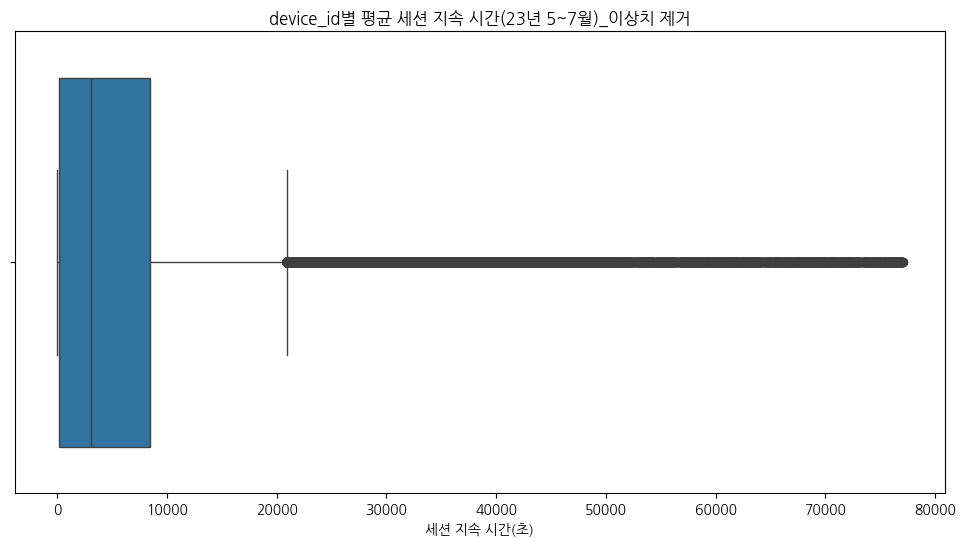

In [29]:
plt.figure(figsize=(12,6))
sns.boxplot(data=avg_duration_df, x='avg_duration_sec')
plt.title('device_id별 평균 세션 지속 시간(23년 5~7월)_이상치 제거')
plt.xlabel('세션 지속 시간(초)')
plt.show()

### device_id별 세션 쌍 개수 집계


In [11]:
#  유저별 세션 개수 구하기
session_counts_df = cleaned_df.groupby('device_id').size().reset_index(name='session_count')
show_df_info(session_counts_df,'session_counts_df')


session_counts_df 형태:


(711926, 2)


session_counts_df 첫 5행:


,device_id,session_count
0,0000065b-8c82-4982-b67e-ac67b1e4c38e,35
1,000007c9-e103-4eb5-9777-a9084d4952df,7
2,00002245-458f-4cdd-8533-b448cd43dbd2,8
3,00004f65-e8bd-4a40-98af-202f2929dd6d,5
4,00005a56-8ccf-4240-90a0-04fbcf90a45b,16



session_counts_df 정보:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 711926 entries, 0 to 711925
Data columns (total 2 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   device_id      711926 non-null  object
 1   session_count  711926 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 10.9+ MB

session_counts_df 통계 요약:


,session_count
count,711926.000000
mean,17.964974
std,20.856945
min,1.000000
25%,2.000000
50%,10.000000
75%,27.000000
max,303.000000



session_counts_df 통계 요약:


,device_id
count,711926
unique,711926
top,0000065b-8c82-4982-b67e-ac67b1e4c38e
freq,1



session_counts_df 결측치 확인:


device_id        0
session_count    0
dtype: int64

In [31]:
# 세션 쌍 개수 최대인 device 탐색
session_counts_df[session_counts_df['session_count'] == 303]

,device_id,session_count
561535,ca1a4a21-36a2-45cc-b7d2-09c4404ccaf0,303


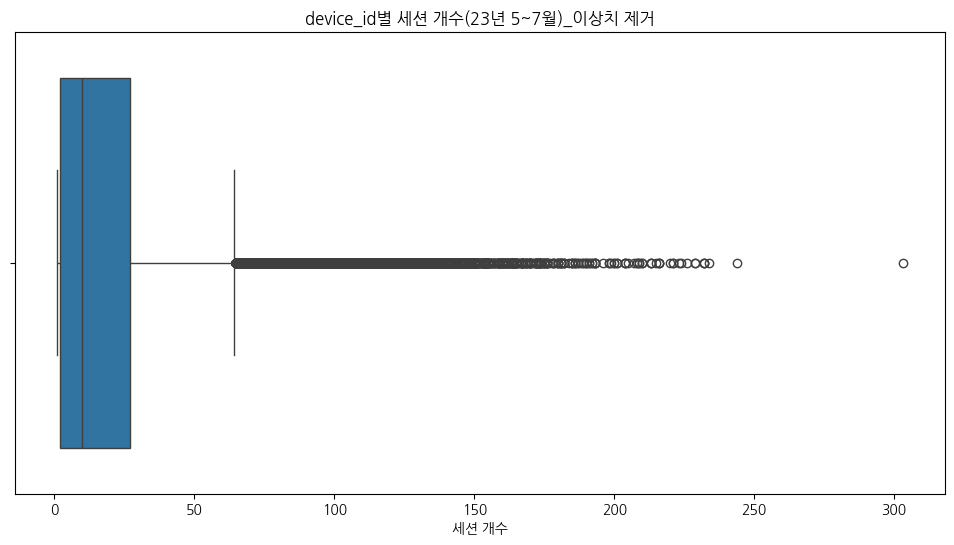

In [32]:
# 박스플롯
plt.figure(figsize=(12,6))
sns.boxplot(data=session_counts_df, x='session_count')
plt.title('device_id별 세션 개수(23년 5~7월)_이상치 제거')
plt.xlabel('세션 개수')
plt.show()

In [12]:
# device_id 별 평균 세션 지속 시간 + 세션 쌍 개수 merge
session_cnt_duration_df = pd.merge(avg_duration_df, session_counts_df, on = 'device_id', how = 'left')
show_df_info(session_cnt_duration_df,'session_cnt_duration_df')


session_cnt_duration_df 형태:


(711926, 3)


session_cnt_duration_df 첫 5행:


,device_id,avg_duration_sec,session_count
0,0000065b-8c82-4982-b67e-ac67b1e4c38e,2386.457143,35
1,000007c9-e103-4eb5-9777-a9084d4952df,81.000000,7
2,00002245-458f-4cdd-8533-b448cd43dbd2,4598.125000,8
3,00004f65-e8bd-4a40-98af-202f2929dd6d,20671.200000,5
4,00005a56-8ccf-4240-90a0-04fbcf90a45b,9998.250000,16



session_cnt_duration_df 정보:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 711926 entries, 0 to 711925
Data columns (total 3 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   device_id         711926 non-null  object 
 1   avg_duration_sec  711926 non-null  float64
 2   session_count     711926 non-null  int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 16.3+ MB

session_cnt_duration_df 통계 요약:


,avg_duration_sec,session_count
count,711926.000000,711926.000000
mean,5603.163180,17.964974
std,7190.689590,20.856945
min,1.000000,1.000000
25%,141.000000,2.000000
50%,3129.048131,10.000000
75%,8452.293269,27.000000
max,77034.000000,303.000000



session_cnt_duration_df 통계 요약:


,device_id
count,711926
unique,711926
top,0000065b-8c82-4982-b67e-ac67b1e4c38e
freq,1



session_cnt_duration_df 결측치 확인:


device_id           0
avg_duration_sec    0
session_count       0
dtype: int64

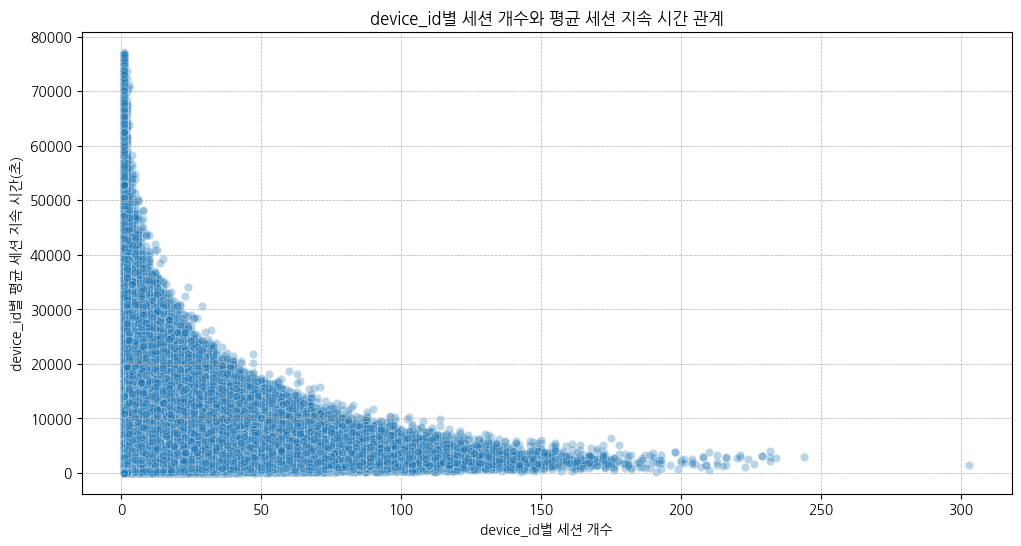

In [34]:
# 유저별 세션 개수와 평균 세션 지속 시간 관계
plt.figure(figsize=(12,6))
sns.scatterplot(
    data=session_cnt_duration_df,
    x='session_count',
    y='avg_duration_sec',
    alpha=0.3
)
plt.xlabel('device_id별 세션 개수')
plt.ylabel('device_id별 평균 세션 지속 시간(초)')
plt.title('device_id별 세션 개수와 평균 세션 지속 시간 관계')
plt.grid(True, which="both", ls="--", linewidth=0.5)
plt.show()

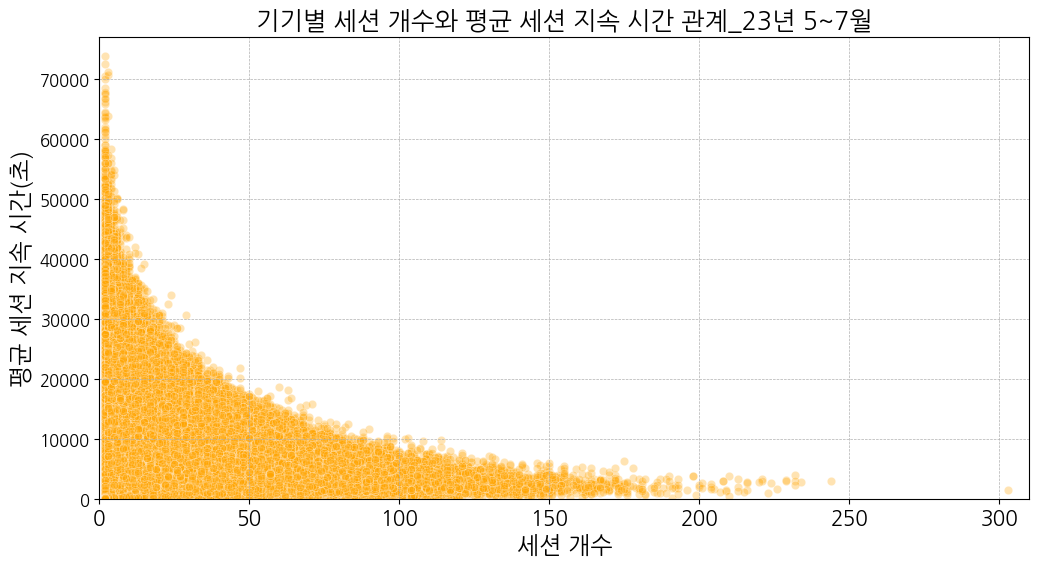

In [20]:
# 세션 개수가 2 이상인 경우만 추출
filtered_df = session_cnt_duration_df[session_cnt_duration_df['session_count'] >= 2]

# 유저별 세션 개수와 평균 세션 지속 시간 관계
plt.figure(figsize=(12,6))
sns.scatterplot(
    data=filtered_df,
    x='session_count',
    y='avg_duration_sec',
    alpha=0.3,
    color = 'Orange'
)
plt.title('기기별 세션 개수와 평균 세션 지속 시간 관계_23년 5~7월', fontsize = 18)
plt.xlabel('세션 개수', fontsize = 17)
plt.ylabel('평균 세션 지속 시간(초)', fontsize = 17)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 12)
plt.xlim(0,310)
plt.ylim(0,77000)
plt.grid(True, which="both", ls="--", linewidth=0.5)
plt.show()

In [ ]:
filtered_df.shape[0] / session_cnt_duration_df.shape[0] * 100 # 세션 쌍 2개 이상인 경우가 전체의 약 80%

79.89959630635768

In [37]:
show_df_info(filtered_df, 'filtered_df')


filtered_df 형태:


(568826, 3)


filtered_df 첫 5행:


,device_id,avg_duration_sec,session_count
0,0000065b-8c82-4982-b67e-ac67b1e4c38e,2386.457143,35
1,000007c9-e103-4eb5-9777-a9084d4952df,81.000000,7
2,00002245-458f-4cdd-8533-b448cd43dbd2,4598.125000,8
3,00004f65-e8bd-4a40-98af-202f2929dd6d,20671.200000,5
4,00005a56-8ccf-4240-90a0-04fbcf90a45b,9998.250000,16



filtered_df 정보:
<class 'pandas.core.frame.DataFrame'>
Index: 568826 entries, 0 to 711924
Data columns (total 3 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   device_id         568826 non-null  object 
 1   avg_duration_sec  568826 non-null  float64
 2   session_count     568826 non-null  int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 17.4+ MB

filtered_df 통계 요약:


,avg_duration_sec,session_count
count,568826.000000,568826.000000
mean,6732.722525,22.232866
std,6870.637203,21.303262
min,1.000000,2.000000
25%,1406.000000,5.000000
50%,4800.127717,16.000000
75%,9889.177778,33.000000
max,73779.000000,303.000000



filtered_df 통계 요약:


,device_id
count,568826
unique,568826
top,0000065b-8c82-4982-b67e-ac67b1e4c38e
freq,1



filtered_df 결측치 확인:


device_id           0
avg_duration_sec    0
session_count       0
dtype: int64

# 가설 확인
- 유저별 세션 쌍 개수 & 평균 세션 지속 시간에 따라 세그먼트 분류 -> 각 세그먼트 별 주 활동 시간대에는 차이가 있을 것이다.
- 주 활동 시간대 == start_time, end_time의 시간대

In [14]:
show_df_info(session_cnt_duration_df,'session_cnt_duration_df')


session_cnt_duration_df 형태:


(711926, 3)


session_cnt_duration_df 첫 5행:


,device_id,avg_duration_sec,session_count
0,0000065b-8c82-4982-b67e-ac67b1e4c38e,2386.457143,35
1,000007c9-e103-4eb5-9777-a9084d4952df,81.000000,7
2,00002245-458f-4cdd-8533-b448cd43dbd2,4598.125000,8
3,00004f65-e8bd-4a40-98af-202f2929dd6d,20671.200000,5
4,00005a56-8ccf-4240-90a0-04fbcf90a45b,9998.250000,16



session_cnt_duration_df 정보:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 711926 entries, 0 to 711925
Data columns (total 3 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   device_id         711926 non-null  object 
 1   avg_duration_sec  711926 non-null  float64
 2   session_count     711926 non-null  int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 16.3+ MB

session_cnt_duration_df 통계 요약:


,avg_duration_sec,session_count
count,711926.000000,711926.000000
mean,5603.163180,17.964974
std,7190.689590,20.856945
min,1.000000,1.000000
25%,141.000000,2.000000
50%,3129.048131,10.000000
75%,8452.293269,27.000000
max,77034.000000,303.000000



session_cnt_duration_df 통계 요약:


,device_id
count,711926
unique,711926
top,0000065b-8c82-4982-b67e-ac67b1e4c38e
freq,1



session_cnt_duration_df 결측치 확인:


device_id           0
avg_duration_sec    0
session_count       0
dtype: int64

## 클러스터 분석

### EDA for 클러스터 분석

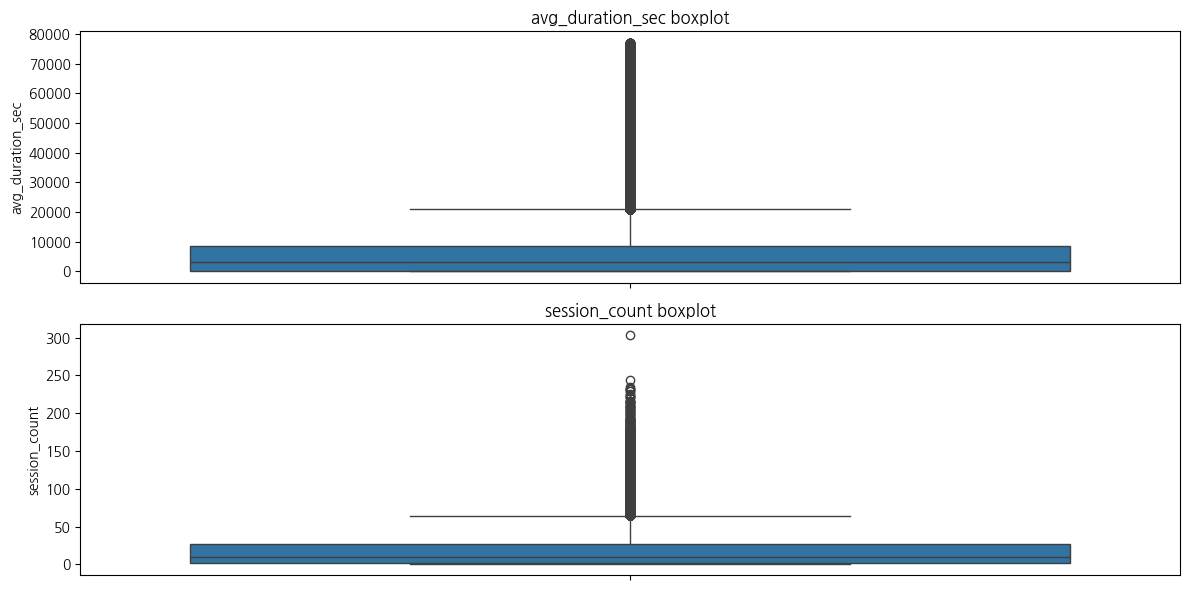

In [16]:
# 이상치 확인
fig, axes = plt.subplots(2,1, figsize = (12,6))

i = 0
for col in session_cnt_duration_df.columns[1:]:
    sns.boxplot(session_cnt_duration_df[col], ax = axes.flat[i])
    axes.flat[i].set_title(f'{col} boxplot')
    i += 1

fig.tight_layout()
plt.show()

In [17]:
# 이상치 확인 함수 
def outliers_idx(df, col):
    q3 = df[col].quantile(0.75)
    q1 = df[col].quantile(0.25)
    
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr
    
    outlier_check = (df[col] < lower) | (df[col] > upper)
    return outlier_check

# 컬럼별 이상치가 전체 데이터에서 차지하는 비율 확인
original_size = session_cnt_duration_df.shape[0]
outlier_list = []

for col in session_cnt_duration_df.columns[1:]:
    outlier_mask = outliers_idx(session_cnt_duration_df, col)
    outlier_cnt = outlier_mask.sum() # 이상치 개수
    ratio = outlier_cnt / original_size * 100 # 이상치 비율

    outlier_list.append(
        {'name' : col,
        'cnt' : outlier_cnt,
        'ratio' : ratio.round(2)}
    )

outlier_df = pd.DataFrame(outlier_list)  # 데이터프레임으로 변환
display(outlier_df.sort_values(by = 'ratio', ascending = False))
outlier_df['ratio'].describe()

,name,cnt,ratio
0,avg_duration_sec,28819,4.05
1,session_count,28346,3.98


count    2.000000
mean     4.015000
std      0.049497
min      3.980000
25%      3.997500
50%      4.015000
75%      4.032500
max      4.050000
Name: ratio, dtype: float64

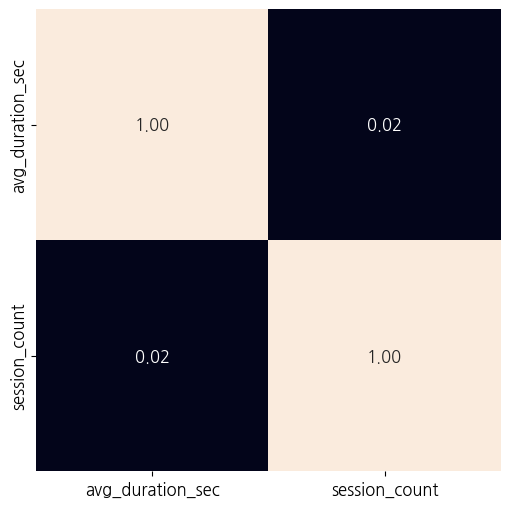

In [20]:
# 상관관계 확인
plt.figure(figsize = (6,6))
sns.heatmap(session_cnt_duration_df.drop(columns = 'device_id').corr(), annot = True, annot_kws = {'size': 12},fmt = '.2f', cbar = False)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.show()

### 스케일러 적용

In [13]:
# 변수 간 스케일 차이 큼 => Standard Scaler

data = session_cnt_duration_df.drop(columns = 'device_id')

ss = StandardScaler()

# StandardScaler 적용
ss_scaled_df =  pd.DataFrame(ss.fit_transform(data), columns = data.columns)
display(ss_scaled_df.head())

,avg_duration_sec,session_count
0,-0.447344,0.816756
1,-0.767961,-0.525723
2,-0.139769,-0.477778
3,2.095494,-0.621615
4,0.611220,-0.094212


### 로그변환 + 스케일러 적용

In [14]:
# 로그 변환
log_transformed_df = np.log1p(session_cnt_duration_df[['session_count', 'avg_duration_sec']])

# StandardScaler 적용
ss = StandardScaler()
ss_scaled_log_df =  pd.DataFrame(ss.fit_transform(log_transformed_df), columns = log_transformed_df.columns)
display(ss_scaled_log_df.head())

,session_count,avg_duration_sec
0,1.070223,0.256677
1,-0.186280,-1.210266
2,-0.087884,0.541965
3,-0.426609,1.195934
4,0.443420,0.879907


### KMEANS

In [24]:
# 경고메시지 처리
os.environ['OMP_NUM_THREADS'] = '1'

In [25]:
# 엘보우 기법, 실루엣 점수로 적절한 군집 수 찾기
def elbow_silouette(df, max_range, title_el, title_sil):
    
    # 클러스터링 및 inertias, 실루엣 점수 계산 
    inertias = []
    sil_scores = []
    
    for k in range(1,max_range+1):
        km = KMeans(n_clusters = k, random_state = 42)
        km.fit(df)
        inertias.append(km.inertia_) # inertias에 저장

        if k >= 2: # 실루엣 점수는 k >=2 일 때 가능
            labels = km.predict(df)
            score = silhouette_score(df, labels, sample_size=5000, random_state = 42)
            sil_scores.append(score) # silhouette_scores에 저장
        
    # 엘보우 기법 - k값에 따른 inertia값 시각화
    fig, ax = plt.subplots(1,2, figsize = (10,5))
    
    sns.lineplot(x = range(1, max_range+1), y = inertias, marker='o', ax = ax[0])
    ax[0].set_title(title_el)
    ax[0].set_xlabel('n-clusters')
    ax[0].set_ylabel('inertia')
    ax[0].grid()
    
    # k값에 따른 실루엣 점수 시각화
    sns.lineplot(x = range(2, max_range+1), y = sil_scores, marker = 'o', ax = ax[1])
    ax[1].set_title(title_sil)
    ax[1].set_xlabel('n_clusters')
    ax[1].set_ylabel('Silhouette Score')
    ax[1].grid()

    plt.tight_layout()
    plt.show()

    return df, inertias, sil_scores


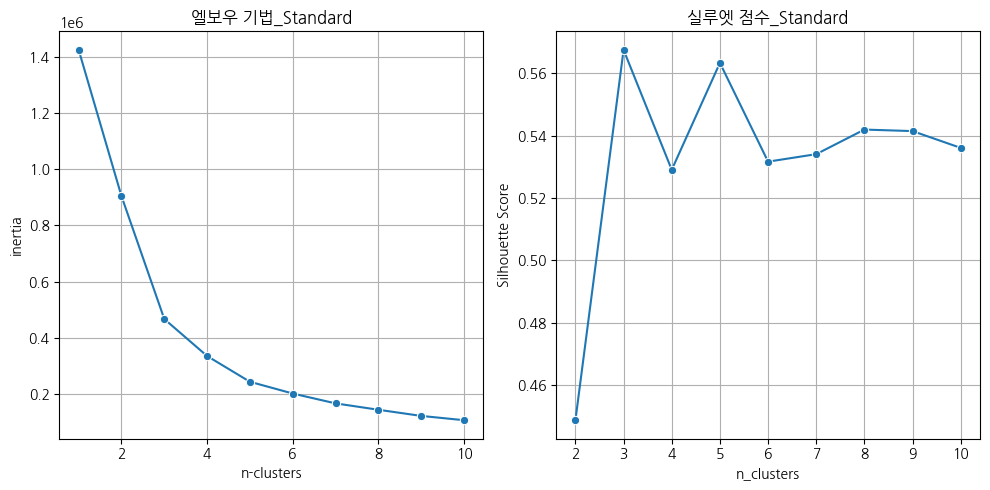

,avg_duration_sec,session_count
0,-0.447344,0.816756
1,-0.767961,-0.525723
2,-0.139769,-0.477778
3,2.095494,-0.621615
4,0.611220,-0.094212
...,...,...
711921,3.140290,-0.573669
711922,4.209243,-0.765452
711923,0.789066,-0.333941
711924,-0.468940,0.864702


[1423851.999999975, 904134.4298424358, 467491.1182942328, 336052.7442765756, 244478.18786700454, 202749.56729880878, 167710.82943313575, 145064.11183347018, 123223.49287840916, 107928.02298841269]
[0.448715297438179, 0.5674984594845729, 0.5290383817117524, 0.5633274961335618, 0.5316497141048413, 0.5340533969449368, 0.541942669284146, 0.5414503642027662, 0.5360654283200439]


In [26]:
# standard 적용 버전
ss_scaled_df_test, inertias, sil_scores = elbow_silouette(ss_scaled_df, 10, '엘보우 기법_Standard', '실루엣 점수_Standard')
display(ss_scaled_df_test)
print(inertias)
print(sil_scores)

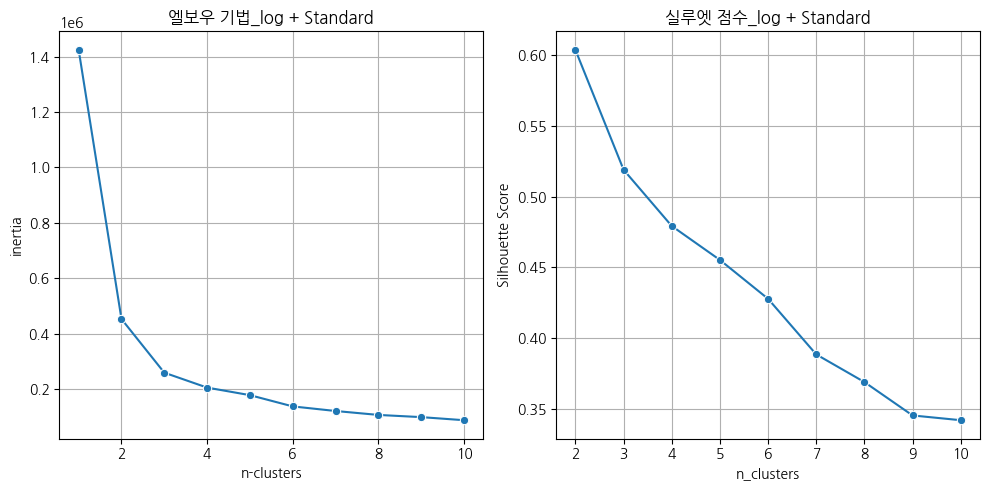

,session_count,avg_duration_sec
0,1.070223,0.256677
1,-0.186280,-1.210266
2,-0.087884,0.541965
3,-0.426609,1.195934
4,0.443420,0.879907
...,...,...
711921,-0.297832,1.330825
711922,-1.005662,1.435758
711923,0.152445,0.932276
711924,1.093112,0.227412


[1423851.999999941, 453287.3309629236, 259845.3017264446, 206061.5313614097, 178816.15820982837, 138229.71078347176, 121681.966611691, 107496.57439862301, 99593.46768935103, 88460.69425210035]
[0.603956529203233, 0.5190947284291497, 0.4792700122439688, 0.45522276287329666, 0.4277121621279499, 0.38834688654571137, 0.36877760656912295, 0.3451376459916933, 0.3417671808860296]


In [27]:
# 로그 변환 + standard 적용 버전
ss_scaled_log_df_test, inertias, sil_scores = elbow_silouette(ss_scaled_log_df, 10, '엘보우 기법_log + Standard', '실루엣 점수_log + Standard')
display(ss_scaled_log_df_test)
print(inertias)
print(sil_scores)

- 로그 변환 + standard 한 경우가 실루엣 점수가 더 높음 
- 실루엣 점수가 쭉 우하향하고 있음...
- k = 2일때 최고점수지만 클러스터로는 너무 단순함
- 스케일링만 한 경우엔 k = 4일 때 최고점, 로그 변환까지 한 경우에도 k = 4는 0.455로 조금 낮지만 적당한 수준의 클러스터!

In [15]:
# KMeans (k = 4)
kmeans = KMeans(n_clusters=4, random_state=42)
# robust 버전
kmeans.fit(ss_scaled_log_df)
predict = kmeans.predict(ss_scaled_log_df)
session_cnt_duration_df['cluster'] = predict

# 확인
pd.Series(predict).value_counts()
display(session_cnt_duration_df)


,device_id,avg_duration_sec,session_count,cluster
0,0000065b-8c82-4982-b67e-ac67b1e4c38e,2386.457143,35,0
1,000007c9-e103-4eb5-9777-a9084d4952df,81.000000,7,2
2,00002245-458f-4cdd-8533-b448cd43dbd2,4598.125000,8,3
3,00004f65-e8bd-4a40-98af-202f2929dd6d,20671.200000,5,3
4,00005a56-8ccf-4240-90a0-04fbcf90a45b,9998.250000,16,3
...,...,...,...,...
711921,ffff2485-894d-4854-b4f0-a3b5c79c23d5,28184.000000,6,3
711922,ffff42a5-d020-4be2-b133-95b1ed1eb99b,35870.500000,2,3
711923,ffff52c1-75aa-4936-b77d-32b77bdf1dc9,11277.090909,11,3
711924,ffff80ca-d517-40f4-bdef-e759411e1fe7,2231.166667,36,0


,count
cluster,
0,274436
1,181654
3,172029
2,83807


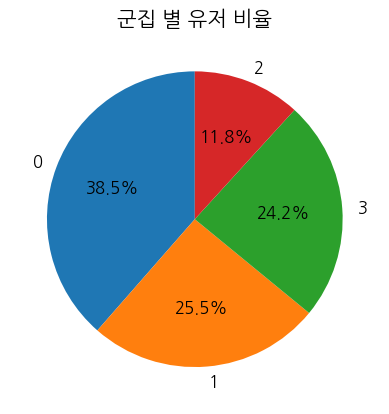

In [16]:
# 각 클러스터별 고객 분포
cluster_df = session_cnt_duration_df['cluster'].value_counts().to_frame()
display(cluster_df)

# 시각화
plt.pie(data = cluster_df, labels = cluster_df.index, x = 'count', autopct='%1.1f%%', startangle = 90, textprops = {'size': 12})
plt.title('군집 별 유저 비율', fontsize = 15)
plt.show()

In [17]:
session_cnt_duration_df.drop(columns = 'device_id').groupby('cluster').mean().round(2)

,avg_duration_sec,session_count
cluster,,
0,5808.77,38.63
1,63.07,1.48
2,729.45,6.12
3,13499.53,8.18


- 클러스터 0 (38.5%) : 지속적 활동자
    - 평균 체류 시간 : 5809초 (1시간 36분)
    - 평균 세션 쌍 개수 : 39개
    -> 비교적 체류시간 길고, 접속 자주 함
- 클러스터 1 (25.5%) : 단발성 사용자
    - 평균 체류 시간 : 63초
    - 평균 세션 쌍 개수 : 1.5개
    -> 매우 짧게 체류하고, 접속도 거의 안함 
- 클러스터 2 (11.8%) : 가벼운 반복 사용자
    - 평균 체류 시간 : 729초 (12분)
    - 평균 세션 쌍 개수 : 6개
    -> 접속은 꽤 하지만, 체류시간이 길지는 않음
- 클러스터 3 (24.2%) : 헤비 사용자
    - 평균 체류 시간 : 13499초 (3시간 45분)
    - 평균 세션 쌍 개수 : 8개
    -> 접속은 엄청 자주는 아니지만, 한번 접속하면 굉장히 오랜 시간 체류함

## 가설 검정

In [33]:
session_cnt_duration_df['device_id'].nunique(), session_cnt_duration_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 711926 entries, 0 to 711925
Data columns (total 4 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   device_id         711926 non-null  object 
 1   avg_duration_sec  711926 non-null  float64
 2   session_count     711926 non-null  int64  
 3   cluster           711926 non-null  int32  
dtypes: float64(1), int32(1), int64(1), object(1)
memory usage: 19.0+ MB


(711926, None)

In [34]:
cleaned_df['device_id'].nunique(), cleaned_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12789732 entries, 0 to 19984284
Data columns (total 5 columns):
 #   Column                Dtype         
---  ------                -----         
 0   device_id             object        
 1   start_time            datetime64[ns]
 2   end_time              datetime64[ns]
 3   session_duration_sec  float64       
 4   session_flag          object        
dtypes: datetime64[ns](2), float64(1), object(2)
memory usage: 585.5+ MB


(711926, None)

In [18]:
# session_cnt_duration_df 와 cleaned_df 병합
session_cluster_df = pd.merge(cleaned_df, session_cnt_duration_df, on = 'device_id', how = 'left')
show_df_info(session_cluster_df,'session_cluster_df')


session_cluster_df 형태:


(12789732, 8)


session_cluster_df 첫 5행:


,device_id,start_time,end_time,session_duration_sec,session_flag,avg_duration_sec,session_count,cluster
0,00018a1a-4204-4efe-8a7f-b4b591d7bb2d,2023-05-11 21:47:43,2023-05-11 21:48:05,22.0,matched,4375.372881,59,0
1,00018a1a-4204-4efe-8a7f-b4b591d7bb2d,2023-05-11 21:48:06,2023-05-11 21:49:50,104.0,matched,4375.372881,59,0
2,00018a1a-4204-4efe-8a7f-b4b591d7bb2d,2023-05-11 22:52:45,2023-05-12 00:49:43,7018.0,matched,4375.372881,59,0
3,00018a1a-4204-4efe-8a7f-b4b591d7bb2d,2023-05-12 03:23:34,2023-05-12 03:24:09,35.0,matched,4375.372881,59,0
4,00018a1a-4204-4efe-8a7f-b4b591d7bb2d,2023-05-12 03:26:37,2023-05-12 04:44:56,4699.0,matched,4375.372881,59,0



session_cluster_df 정보:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12789732 entries, 0 to 12789731
Data columns (total 8 columns):
 #   Column                Dtype         
---  ------                -----         
 0   device_id             object        
 1   start_time            datetime64[ns]
 2   end_time              datetime64[ns]
 3   session_duration_sec  float64       
 4   session_flag          object        
 5   avg_duration_sec      float64       
 6   session_count         int64         
 7   cluster               int32         
dtypes: datetime64[ns](2), float64(2), int32(1), int64(1), object(2)
memory usage: 731.8+ MB

session_cluster_df 통계 요약:


,start_time,end_time,session_duration_sec,avg_duration_sec,session_count,cluster
count,12789732,12789732,1.278973e+07,1.278973e+07,1.278973e+07,1.278973e+07
mean,2023-05-18 13:10:08.910161408,2023-05-18 14:45:57.562395392,5.748652e+03,5.748652e+03,4.217940e+01,4.313099e-01
min,2023-05-01 09:00:01,2023-05-01 09:00:08,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00
25%,2023-05-12 15:41:33,2023-05-12 17:22:01,5.300000e+01,2.323773e+03,2.200000e+01,0.000000e+00
50%,2023-05-16 06:43:56,2023-05-16 07:39:28,3.530000e+02,4.496969e+03,3.800000e+01,0.000000e+00
75%,2023-05-19 17:14:08,2023-05-19 19:09:50,3.214000e+03,7.849550e+03,5.700000e+01,0.000000e+00
max,2023-07-12 08:59:35,2023-07-12 08:59:59,7.705700e+04,7.703400e+04,3.030000e+02,3.000000e+00
std,NaN,NaN,1.335345e+04,4.858001e+03,2.740219e+01,9.927908e-01



session_cluster_df 통계 요약:


,device_id,session_flag
count,12789732,12789732
unique,711926,1
top,ca1a4a21-36a2-45cc-b7d2-09c4404ccaf0,matched
freq,303,12789732



session_cluster_df 결측치 확인:


device_id               0
start_time              0
end_time                0
session_duration_sec    0
session_flag            0
avg_duration_sec        0
session_count           0
cluster                 0
dtype: int64

In [21]:
# 시간대 컬럼 추가 
session_cluster_df['start_hour'] = session_cluster_df['start_time'].dt.hour

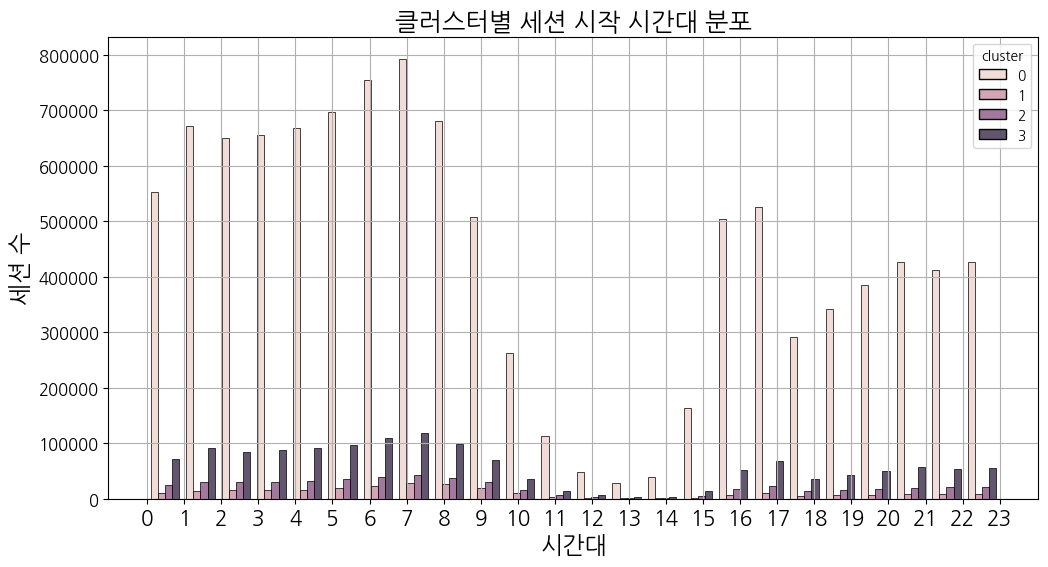

In [22]:
# 클러스터별 session_start_time 분포 
plt.figure(figsize=(12, 6))
sns.histplot(data=session_cluster_df, x='start_hour', hue='cluster', bins=24, multiple='dodge', shrink=0.8)
plt.title('클러스터별 세션 시작 시간대 분포', fontsize = 18)
plt.xlabel('시간대', fontsize = 17)
plt.ylabel('세션 수', fontsize = 17)
plt.xticks(range(0, 24), fontsize = 15)
plt.yticks(fontsize = 12)
plt.grid(True)
plt.show()

In [19]:
# 1. 세션별 활동 시간 리스트 생성 함수
def expand_hours(row):
    start = row['start_time']
    end = row['end_time']

    # 당일 넘는 경우 방지
    if end < start:
        end += pd.Timedelta(days=1)

    return list(range(start.hour, end.hour + 1))

# 2. 각 세션별 활동 시간대 추출
session_cluster_df['active_hours'] = session_cluster_df.apply(expand_hours, axis=1)

# 3. 활동 시간대 단위로 explode (long format)
exploded_df = session_cluster_df.explode('active_hours')

In [20]:
# 4. 클러스터별 시간대별 빈도표 생성
hourly_cluster_table = pd.crosstab(exploded_df['active_hours'], exploded_df['cluster'])

# 5. 카이제곱 검정 수행
chi2, p, dof, expected = chi2_contingency(hourly_cluster_table)

print(f"\n📌 [카이제곱 검정 결과]")
print(f"Chi2 통계량: {chi2:.2f}")
print(f"p-value: {p: .6f}")
print("p-value (지수 표기):", format(p, ".10e")) # p < 5e-324(파이썬에서 가능한 가장 작은 양의 실수) 수준
if p < 0.05:
    print("→ 유의수준 0.05 하에 귀무가설 기각: 클러스터별 활동 시간대에 통계적으로 유의한 차이가 있음!")
else:
    print("→ 유의수준 0.05 하에 귀무가설 채택: 활동 시간대 분포 차이가 유의하지 않음.")


📌 [카이제곱 검정 결과]
Chi2 통계량: 241102.71
p-value:  0.000000
p-value (지수 표기): 0.0000000000e+00
→ 유의수준 0.05 하에 귀무가설 기각: 클러스터별 활동 시간대에 통계적으로 유의한 차이가 있음!


In [ ]:
# 6. 시각화: heatmap으로 활동 시간 분포 보기
plt.figure(figsize=(12, 6))
sns.heatmap(hourly_cluster_table, cmap='Oranges', annot=True, annot_kws = {'size': 12}, fmt='d', )
plt.title("클러스터별 활동 시간대 분포_23년 5~7월", fontsize = 18)
plt.xlabel("클러스터", fontsize = 17)
plt.ylabel("시간대", fontsize = 17)
plt.yticks(np.arange(0.5, 24.5), labels=[f"{i}시" for i in range(24)], rotation=0, fontsize = 12)
plt.xticks(rotation=0, fontsize = 15)
plt.tight_layout()
plt.show()

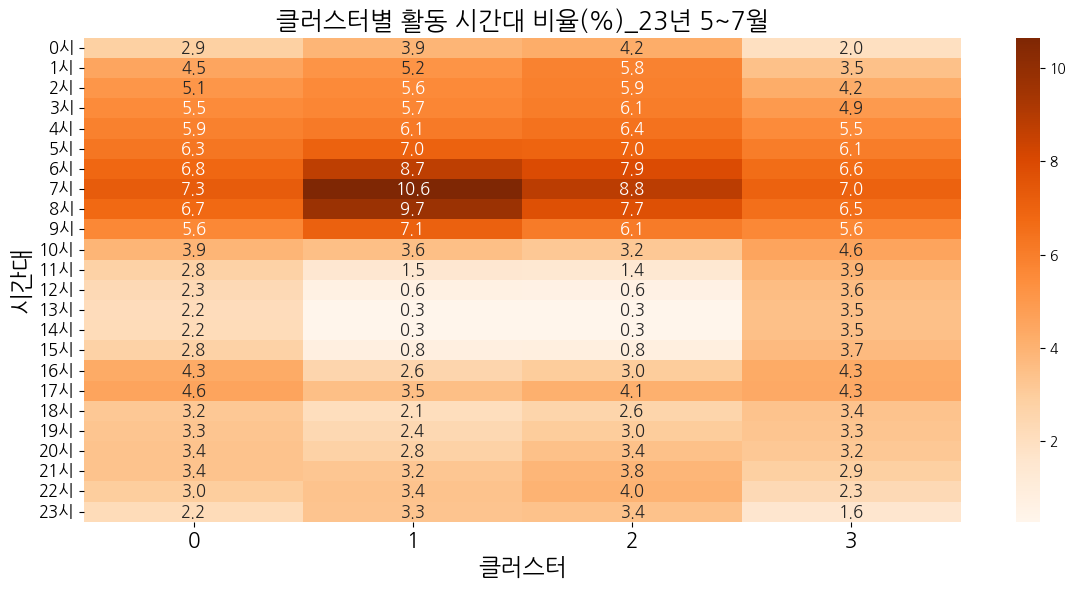

In [26]:
# 비율 계산: 각 클러스터 내에서의 시간대 분포 (column-wise)
hourly_cluster_ratio = hourly_cluster_table.div(hourly_cluster_table.sum(axis=0), axis=1) * 100

# 시각화
plt.figure(figsize=(12, 6))
sns.heatmap(hourly_cluster_ratio, cmap='Oranges', annot=True, fmt=".1f", annot_kws={'size': 12})
plt.title("클러스터별 활동 시간대 비율(%)_23년 5~7월", fontsize=18)
plt.xlabel("클러스터", fontsize=17)
plt.ylabel("시간대", fontsize=17)
plt.yticks(np.arange(0.5, 24.5), labels=[f"{i}시" for i in range(24)], rotation=0, fontsize=12)
plt.xticks(rotation=0, fontsize=15)
plt.tight_layout()
plt.show()


# 주중 vs 주말로 비교해보기
- 주중 vs 주말로 나눠서 성공기 -> 쇠퇴기의 아침 -> 저녁 사용 변화가 '학사일정'에 영향을 받는지 아닌지 확인
- session_start로만 우선 확인

In [27]:
session_cluster_df.head()

,device_id,start_time,end_time,session_duration_sec,session_flag,avg_duration_sec,session_count,cluster,start_hour,active_hours
0,00018a1a-4204-4efe-8a7f-b4b591d7bb2d,2023-05-11 21:47:43,2023-05-11 21:48:05,22.0,matched,4375.372881,59,0,21,[21]
1,00018a1a-4204-4efe-8a7f-b4b591d7bb2d,2023-05-11 21:48:06,2023-05-11 21:49:50,104.0,matched,4375.372881,59,0,21,[21]
2,00018a1a-4204-4efe-8a7f-b4b591d7bb2d,2023-05-11 22:52:45,2023-05-12 00:49:43,7018.0,matched,4375.372881,59,0,22,[]
3,00018a1a-4204-4efe-8a7f-b4b591d7bb2d,2023-05-12 03:23:34,2023-05-12 03:24:09,35.0,matched,4375.372881,59,0,3,[3]
4,00018a1a-4204-4efe-8a7f-b4b591d7bb2d,2023-05-12 03:26:37,2023-05-12 04:44:56,4699.0,matched,4375.372881,59,0,3,"[3, 4]"


In [28]:
session_cluster_df = session_cluster_df.copy()

# datetime에서 시간, 요일 추출
session_cluster_df['start_hour'] = session_cluster_df['start_time'].dt.hour
session_cluster_df['start_dayofweek'] = session_cluster_df['start_time'].dt.dayofweek

# 주중/주말 구분 (0~4: 주중(weekdays), 5~6: 주말(weekend))
session_cluster_df['is_weekend'] = session_cluster_df['start_dayofweek'].apply(lambda x: 'weekend' if x >= 5 else 'weekdays')

session_cluster_df.head()

,device_id,start_time,end_time,session_duration_sec,session_flag,avg_duration_sec,session_count,cluster,start_hour,active_hours,start_dayofweek,is_weekend
0,00018a1a-4204-4efe-8a7f-b4b591d7bb2d,2023-05-11 21:47:43,2023-05-11 21:48:05,22.0,matched,4375.372881,59,0,21,[21],3,weekdays
1,00018a1a-4204-4efe-8a7f-b4b591d7bb2d,2023-05-11 21:48:06,2023-05-11 21:49:50,104.0,matched,4375.372881,59,0,21,[21],3,weekdays
2,00018a1a-4204-4efe-8a7f-b4b591d7bb2d,2023-05-11 22:52:45,2023-05-12 00:49:43,7018.0,matched,4375.372881,59,0,22,[],3,weekdays
3,00018a1a-4204-4efe-8a7f-b4b591d7bb2d,2023-05-12 03:23:34,2023-05-12 03:24:09,35.0,matched,4375.372881,59,0,3,[3],4,weekdays
4,00018a1a-4204-4efe-8a7f-b4b591d7bb2d,2023-05-12 03:26:37,2023-05-12 04:44:56,4699.0,matched,4375.372881,59,0,3,"[3, 4]",4,weekdays


In [31]:
# 그룹별 시간대별 활동 수 집계
hourly_activity = (
    session_cluster_df.groupby(['start_hour', 'is_weekend'])
    .size()
    .reset_index(name='count')
)

# 히트맵용 피벗
hourly_week_table  = hourly_activity.pivot(index='start_hour', columns='is_weekend', values='count')
display(hourly_week_table)

# 전체 대비 시간대 비율 정규화 (열 기준 = 주중/주말 별 비율)
hourly_week_ratio = hourly_week_table.div(hourly_week_table.sum(axis=0), axis=1) * 100
hourly_week_ratio

is_weekend,weekdays,weekend
start_hour,,
0,455955,203701
1,581332,225602
2,554485,225178
3,560656,227936
4,565322,241972
5,598055,249930
6,653319,273058
7,697317,285727
8,582294,260207


is_weekend,weekdays,weekend
start_hour,,
0,5.289123,4.885953
1,6.743508,5.411268
2,6.432080,5.401098
3,6.503664,5.467251
4,6.557790,5.803918
5,6.937496,5.994797
6,7.578564,6.549543
7,8.088945,6.853421
8,6.754667,6.241301


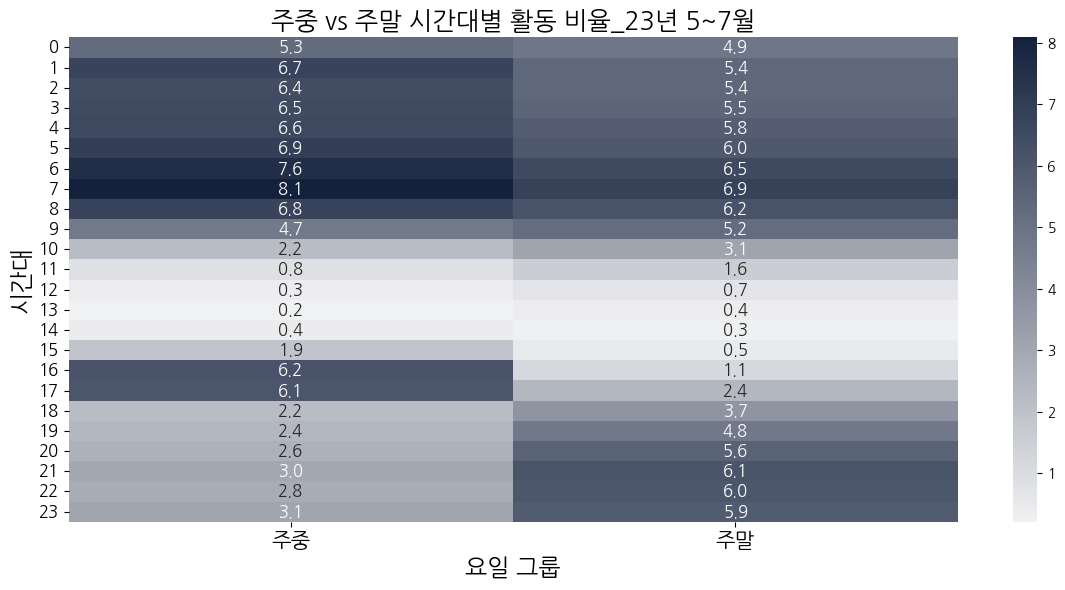

In [34]:
# 단일 색상 계열로 커스텀 컬러맵 만들기
custom_cmap = sns.light_palette("#14213D", as_cmap=True)

# 히트맵 시각화
plt.figure(figsize=(12, 6))
sns.heatmap(hourly_week_ratio, cmap=custom_cmap, annot=True, fmt=".1f", annot_kws={'size': 12})
plt.title("주중 vs 주말 시간대별 활동 비율_23년 5~7월", fontsize=18)
plt.xlabel("요일 그룹", fontsize=17)
plt.ylabel("시간대", fontsize=17)
plt.xticks([0.5,1.5], ['주중', '주말'], fontsize=15)
plt.yticks(rotation=0, fontsize=12)
plt.tight_layout()
plt.show()

<Axes: xlabel='start_hour'>

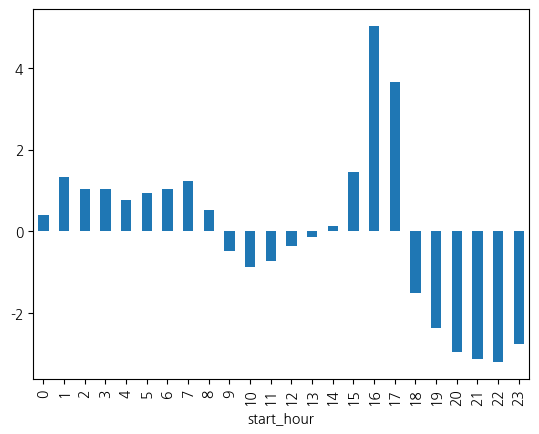

In [60]:
# 차이값(= 주중 - 주말) 시리즈를 시각화
(hourly_week_ratio['weekdays'] - hourly_week_ratio['weekend']).plot(kind='bar')


In [ ]:
# 전체 시계열(0~23시)에 대한 분포 차이 검정 // 역시 차이는 없었다..... 
# Kolmogorov–Smirnov (KS) test
from scipy.stats import ks_2samp

ks_stat, pval = ks_2samp(
    hourly_week_ratio['weekdays'].values,
    hourly_week_ratio['weekend'].values
)
print(f"KS 통계량: {ks_stat:.3f}, p-value: {pval:.4f}")


KS 통계량: 0.250, p-value: 0.4490
